# P2 submission

**Team :** Laremontada61

📖 Abstract

In the wide world of hops, cereals and aperitifs with friends, LaRemontADA is on a quest towards making a beer rating system combining the precision of figures and the richness of prose.

Using the BeerReviews dataset that contains a variety of beer ratings from 2 different websites together with sentiment analysis tools, out goal is to enhance the already existing rating system to be able to determine the world's best beer. This determination is based on a detailed analysis of the existing ratings throughout the world and across time.

❓ **Research questions**

During this work, we will give an answer to those questions:

- How to enrich the ranking systems with sentiment analysis ?
- Are there any external factors that may influence rating ? (such as politics, economics, time of the year...)
- Combining all of this, what is the best brewery in the world ?

---

# Introduction

The notebook's objective for this milestone is to intimately familiarize ourselves with the data, perform thorough preprocessing, and execute all essential descriptive statistical tasks and showcasing the feasibility of our project goals.

General organization of this notebook:
- Handle size of the data
- EDA
- Data preprocessing
- Feasibility check of projects' methods
- Alternatives considered

In [21]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import warnings
import spacy

from textblob import TextBlob
from IPython.display import display, HTML, Markdown

from sklearn.feature_extraction.text import CountVectorizer

import string
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from collections import Counter

warnings.filterwarnings('ignore') # remove the warnings

---

## Handle size of the data

### Load ratings.txt

We are processing data extracted from two similar beer rating websites: BeerAdvocate and RateBeer. The primary data structure is outlined in "ratings.txt," which includes user reviews providing information on beer (names, IDs, style, alcohol by volume), breweries, and users (date of review, user details, ratings, and comments on various aspects). Other supporting files include "beers.csv" (aggregated ratings for each beer), "Breweries" (information on breweries and their locations), and "Users" (user details on the number of ratings, reviews, and country of origin).

The most crucial file is "ratings.txt," as others are derived from its content. Due to its significant size (4.3 GB for BeerAdvocate and 3.95 GB for RateBeer), loading directly with a standard pipeline is impractical due to laptop memory limitations. To address this, we split the .txt files into N subfiles and load the data iteratively using a function.

The function allows control over the fraction of initial data loaded via the parameter **Nb_files**, which determines the number of subfiles to load. It also accommodates inherent differences between the two websites, such as additional review columns for BeerAdvocate.

Once loaded into DataFrames, we utilize the sample_data function to randomly sample a fraction of the data, enabling efficient handling of the substantial dataset.

In [3]:
def load_txt_file(website, Nb_files):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files 
        # Need to be outside of the repo folder and might need to change the path according to one's unique folders configuration
        directory = './../dataset_BeerReviews/BeerAdvocate/ratings_split_BA/'
    else:
        directory = './../dataset_BeerReviews/RateBeer/ratings_split_RB/'

    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(Nb_files, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns depending on the website
    if website == 'BeerAdvocate':
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text',
            'review'] # additional column compared to RB
    else:
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text']
    return final_df

def sample_data(df, ratio):
    # sample the data to make it even smaller
    return df.sample(frac = ratio, random_state=42)

In [4]:
# Load data
ratings_BA = load_txt_file('BeerAdvocate', 1)
ratings_RB = load_txt_file('RateBeer', 1)

In [5]:
# Sample data to make it even smaller AND RANDOMIZED (not randomized in the initial txt splitting process)
ratings_BA = sample_data(df = ratings_BA, ratio = 1)
ratings_RB = sample_data(df = ratings_RB, ratio = 1)

In [6]:
print(f"Length of ratings_BA (BeerAdvocate) dataframe : {len(ratings_BA)}")
print(f"Length of ratings_RB (RateBeer) dataframe : {len(ratings_RB)}")
display(ratings_BA.head(2),ratings_RB.head(2))

Length of ratings_BA (BeerAdvocate) dataframe : 444339
Length of ratings_RB (RateBeer) dataframe : 446795


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
43736,"Hello, My Name Is Ingrid",67199,BrewDog,16315,American Double / Imperial IPA,8.2,1370426400,aztraz,aztraz.671249,nan,nan,nan,nan,nan,3.50,nan,False
273843,Solstice D'été Aux Cerises,73716,Brasserie Dieu du Ciel!,1141,Berliner Weissbier,6.5,1444644000,hopsolutely,hopsolutely.513175,4.0,4.0,3.5,4.0,3.75,3.90,Enjoying with thanks to Phyl21ca.Rarely does a...,True


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
262500,Brew Brothers Prairie Berry Ale,21927,Brew Brothers Brewing &#40;Alberta&#41;,3033,Fruit Beer,5.5,1044615600,presario,5348,3,6,3,7,13,3.20,Big blue 1L bottle. Very loud pop announced t...
39881,Ed Hardy Premium Beer,110849,Cervecería Mexicana (Grupo Modelo),5973,Pale Lager,4.6,1281520800,Cajun,47922,2,4,2,3,5,1.60,Tasting - Gulf Brew 2010 - Pale amber white he...


### Load the other data

In [7]:
# BeerAdvocate
beers_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users.csv", header=1)

---

## EDA

**Organisation of the EDA**
- General
- Numerical ratings
- Textual reviews

### 1. General

**Formats**

In [9]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,object,object
brewery_name,object,object
brewery_id,object,object
style,object,object
abv,object,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,object


One can see that all the features of **ratings_BA** and **ratings_RB** have a `object` type, which is not very convenient if we want to automate the visualization process, for example plotting the distribution of the numerical features in histograms. As a first preprocessing step, we will thus convert the type of the numerical variables to `float64` with the function **convert_type** below.

In [10]:
def convert_type(df, col):
    df[col] = df[col].astype('float64')
    return df

# columns including the numerical features for both websites
# user_id is numerical in RB but categorical in BA so we don't include it
numerical_cols = ['beer_id', 'brewery_id', 'abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in numerical_cols : 
    ratings_BA = convert_type(ratings_BA, col)
    ratings_RB = convert_type(ratings_RB, col)

In [11]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,float64,float64
brewery_name,object,object
brewery_id,float64,float64
style,object,object
abv,float64,float64
date,object,object
user_name,object,object
user_id,object,object
appearance,float64,float64


**Descriptive statistics**

We can see the missing values per feature in each dataframe.

In [12]:
def get_feature_stats(df):
        """
        Obtains descriptive statistics for all features and percentage of missing values

        Parameters
        ----------
        df : DataFrame containing all data
        
        Returns
        -------
        stats : DataFrame containing the statistics for all features.
        """
        # Calculate numerical descriptive statistics 
        numerical = df.describe(include= ['float64', 'int64'])
        # Calculate categorical descriptive statistics
        categorical = df.describe(include= ['object'])
        # Combine numerical and categorical statistics into a single DataFrame
        stats = pd.concat([numerical, categorical])
        
        # Select specific statistics for the output
        stats = stats.loc[['mean', 'std', '50%', 'unique', 'freq', 'max']]
        # Calculate the percentage of missing values for each feature
        percentage = df.isnull().sum(axis = 0)*100 / len(df)
        # Add a row to the DataFrame containing the percentage of missing values for each feature
        stats.loc['missing_values'] = np.array(percentage)
        return stats

In [13]:
display(get_feature_stats(ratings_BA), get_feature_stats(ratings_RB))

,beer_id,brewery_id,abv,appearance,aroma,palate,taste,overall,rating,beer_name,brewery_name,style,date,user_name,user_id,text,review
mean,49930.822187,7393.904217,6.283523,3.763298,3.662354,3.670929,3.713133,3.724937,3.676796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,64384.554923,10963.761690,2.314747,0.620217,0.684314,0.672210,0.703822,0.681856,0.690097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,21163.000000,853.000000,5.400000,4.000000,3.750000,3.750000,3.750000,4.000000,3.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22878,1947,104,5809,39863,39863,196394,2
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10046,37472,31061,628,3833,3833,247685,254214
max,293278.000000,49808.000000,67.500000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
missing_values,0.000225,0.000450,0.000450,0.000450,0.000450,0.783636,0.000450,0.000450,0.000450,36.780926,36.780926,36.780926,36.780926,36.780926,0.00045,0.00045,0.00045


,beer_id,brewery_id,abv,appearance,aroma,palate,taste,overall,rating,beer_name,brewery_name,style,date,user_name,user_id,text
mean,143633.215959,6031.760075,6.134699,3.271936,6.057893,3.071982,6.139671,12.431072,3.097255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,145026.596254,7227.842634,1.851008,0.835354,1.759857,0.851453,1.730788,3.602640,0.793646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,95677.000000,2244.000000,5.500000,3.000000,6.000000,3.000000,6.000000,13.000000,3.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30957,1940,89,6089,16554,16551,445825
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3650,28394,62348,298,5320,5320,71
max,536439.000000,32240.000000,30.000000,5.000000,10.000000,5.000000,10.000000,20.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
missing_values,0.000224,0.000224,0.000224,0.000224,0.000224,2.530243,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448


In [14]:
df1 = get_feature_stats(breweries_BA)
df2 = get_feature_stats(breweries_RB)
df3 = get_feature_stats(users_BA)
df4 = get_feature_stats(users_RB)

# Using HTML/CSS to display DataFrames in the same row
html = f'<div style="display: flex; flex-direction: row;"> \
            <div style="text-align: center; margin-right: 20px;"> \
                <h3>Breweries BeerAdvocate</h3>{df1.to_html()} \
            </div> \
            <div style="text-align: center; margin-right: 100px;"> \
                <h3>Breweries RateBeer</h3>{df2.to_html()} \
            </div> \
            <div style="text-align: center; margin-right: 20px;"> \
                <h3>Users BeerAdovate</h3>{df3.to_html()} \
            </div> \
            <div style="text-align: center;"> \
                <h3>Users RateBeer</h3>{df4.to_html()} \
            </div> \
        </div>'

display(HTML(html))

,id,nbr_beers,location,name
mean,25954.841270,21.056331,NaN,NaN
std,16219.989105,69.417841,NaN,NaN
50%,29178.000000,6.000000,NaN,NaN
unique,NaN,NaN,297,16237
freq,NaN,NaN,1431,34
max,49817.000000,1196.000000,NaN,NaN
missing_values,0.000000,0.000000,0.0,0.0
,id,nbr_beers,location,name
mean,16639.680061,19.022655,NaN,NaN
std,9408.751678,31.542620,NaN,NaN


**Graphical descriptions**

- **Users**

In [15]:
display(users_BA.head(2), users_RB.head(2))

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"


,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain


In [82]:
print(f"\nNumber of unique users (based on user_name) in BeerAdvocate: {len(users_BA['user_name'].unique())}")
print(f"Number of unique users (based on user_name) in RateBeer: {len(users_RB['user_name'].unique())}")

print(f"\nNumber of unique location for the users in BeerAdvocate: {len(users_BA['location'].unique())}")
print(f"Number of unique location for the users in RateBeer: {len(users_RB['location'].unique())}")


Number of unique users (based on user_name) in BeerAdvocate: 153704
Number of unique users (based on user_name) in RateBeer: 70174

Number of unique location for the users in BeerAdvocate: 195
Number of unique location for the users in RateBeer: 223


- **Breweries**

In [17]:
display(breweries_BA.head(2), breweries_RB.head(2))

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1


,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13


In [81]:
print(f"\nNumber of unique breweries (based on name) in BeerAdvocate: {len(breweries_BA['name'].unique())}")
print(f"Number of unique breweries (based on name) in RateBeer: {len(breweries_RB['name'].unique())}")

print(f"\nNumber of unique location for the breweries in BeerAdvocate: {len(breweries_BA['location'].unique())}")
print(f"Number of unique location for the breweries in RateBeer: {len(breweries_RB['location'].unique())}")


Number of unique breweries (based on name) in BeerAdvocate: 16237
Number of unique breweries (based on name) in RateBeer: 24173

Number of unique location for the breweries in BeerAdvocate: 297
Number of unique location for the breweries in RateBeer: 267


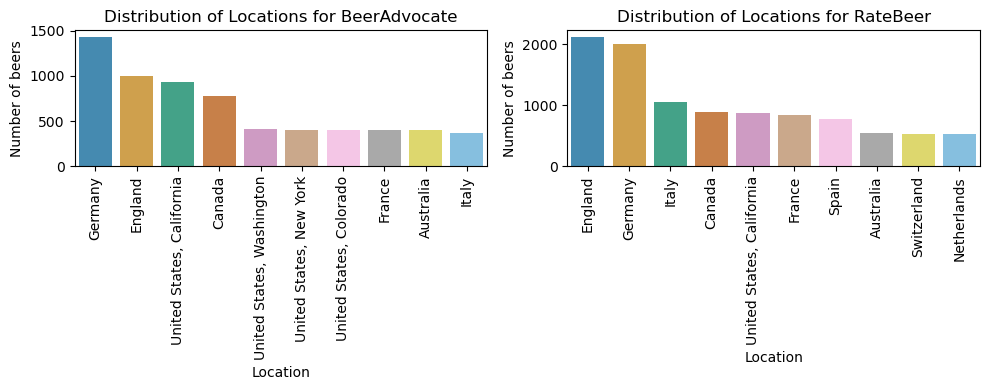

In [ ]:
# Count the number of beers for each location
def count_Top_10(breweries_df):
    # Count the number of beers per location
    number_of_beer_per_country = breweries_df['location'].value_counts()
    # Identify the top 10 breweries by location
    top_10_breweries_location = number_of_beer_per_country.nlargest(10)
    return top_10_breweries_location, number_of_beer_per_country

top_10_breweries_location_RB, _ = count_Top_10(breweries_RB)
top_10_breweries_location_BA, _ = count_Top_10(breweries_BA)

_ , number_of_beer_per_country_RB = count_Top_10(breweries_RB)
_ , number_of_beer_per_country_BA = count_Top_10(breweries_BA)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(x=top_10_breweries_location_BA.index, y=top_10_breweries_location_BA.values, alpha=0.8, palette=sns.color_palette("colorblind"), ax=axs[0])
axs[0].set_title('Distribution of Locations for BeerAdvocate')
axs[0].set_ylabel('Number of beers')
axs[0].set_xlabel('Location')
axs[0].tick_params(axis='x', rotation=90)

sns.barplot(x=top_10_breweries_location_RB.index, y=top_10_breweries_location_RB.values, alpha=0.8, palette=sns.color_palette("colorblind"), ax=axs[1])
axs[1].set_title('Distribution of Locations for RateBeer')
axs[1].set_ylabel('Number of beers')
axs[1].set_xlabel('Location')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

From this plot, one could say that the top 10 location with the greater number of beers seems well spread. But when taking a closer look at the data it is noticeable that in the United States there is a location per state, meaning that the total number of beers in the US is not well represented here.

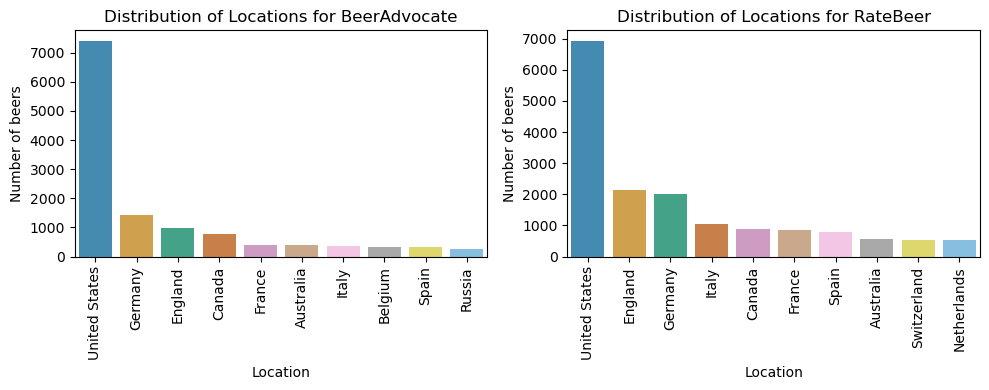

In [20]:
def filtering_us(breweries_df, number_of_beer_per_country):
    # Create a category that gathers all the US beers in one location
    # Count number of beers in the US
    nb_us_beers = breweries_df[breweries_df['location'].str.startswith('United States,')].value_counts().sum()

    # Modify world wide beer count to gather all the US beers in one category 
    us_filtered = number_of_beer_per_country[~number_of_beer_per_country.index.str.startswith('United States,')]
    us_filtered.loc['United States'] = nb_us_beers

    us_filtered = us_filtered.nlargest(10)
    return us_filtered

us_filtered_RB = filtering_us(breweries_RB, number_of_beer_per_country_RB)
us_filtered_BA = filtering_us(breweries_BA, number_of_beer_per_country_BA)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(x=us_filtered_BA.index, y=us_filtered_BA.values, alpha=0.8, palette=sns.color_palette("colorblind"), ax=axs[0])
axs[0].set_title('Distribution of Locations for BeerAdvocate')
axs[0].set_ylabel('Number of beers')
axs[0].set_xlabel('Location')
axs[0].tick_params(axis='x', rotation=90)

sns.barplot(x=us_filtered_RB.index, y=us_filtered_RB.values, alpha=0.8, palette=sns.color_palette("colorblind"), ax=axs[1])
axs[1].set_title('Distribution of Locations for RateBeer')
axs[1].set_ylabel('Number of beers')
axs[1].set_xlabel('Location')
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Now it is more evident that for both datasets (RateBeer and BeerAdvocate) there is a significantly larger number of beers coming from the US, which means that the distribution of the data could be more relevant in this location. This can be interesting if another deeper analysis is done specifically for the US.

- **Ratings** dataframes

As seen above, there are more than  16 000 unique breweries for BeerAdvocate and more than 24 000 for RateBeer. We thus cannot visualize all of them at once. We thus used the function **filter_topk_breweries** to only visualize the breweries that appear the most tn the dataframes ratings.

Number of different breweries in BA : 1962
Number of different breweries in RB : 1942


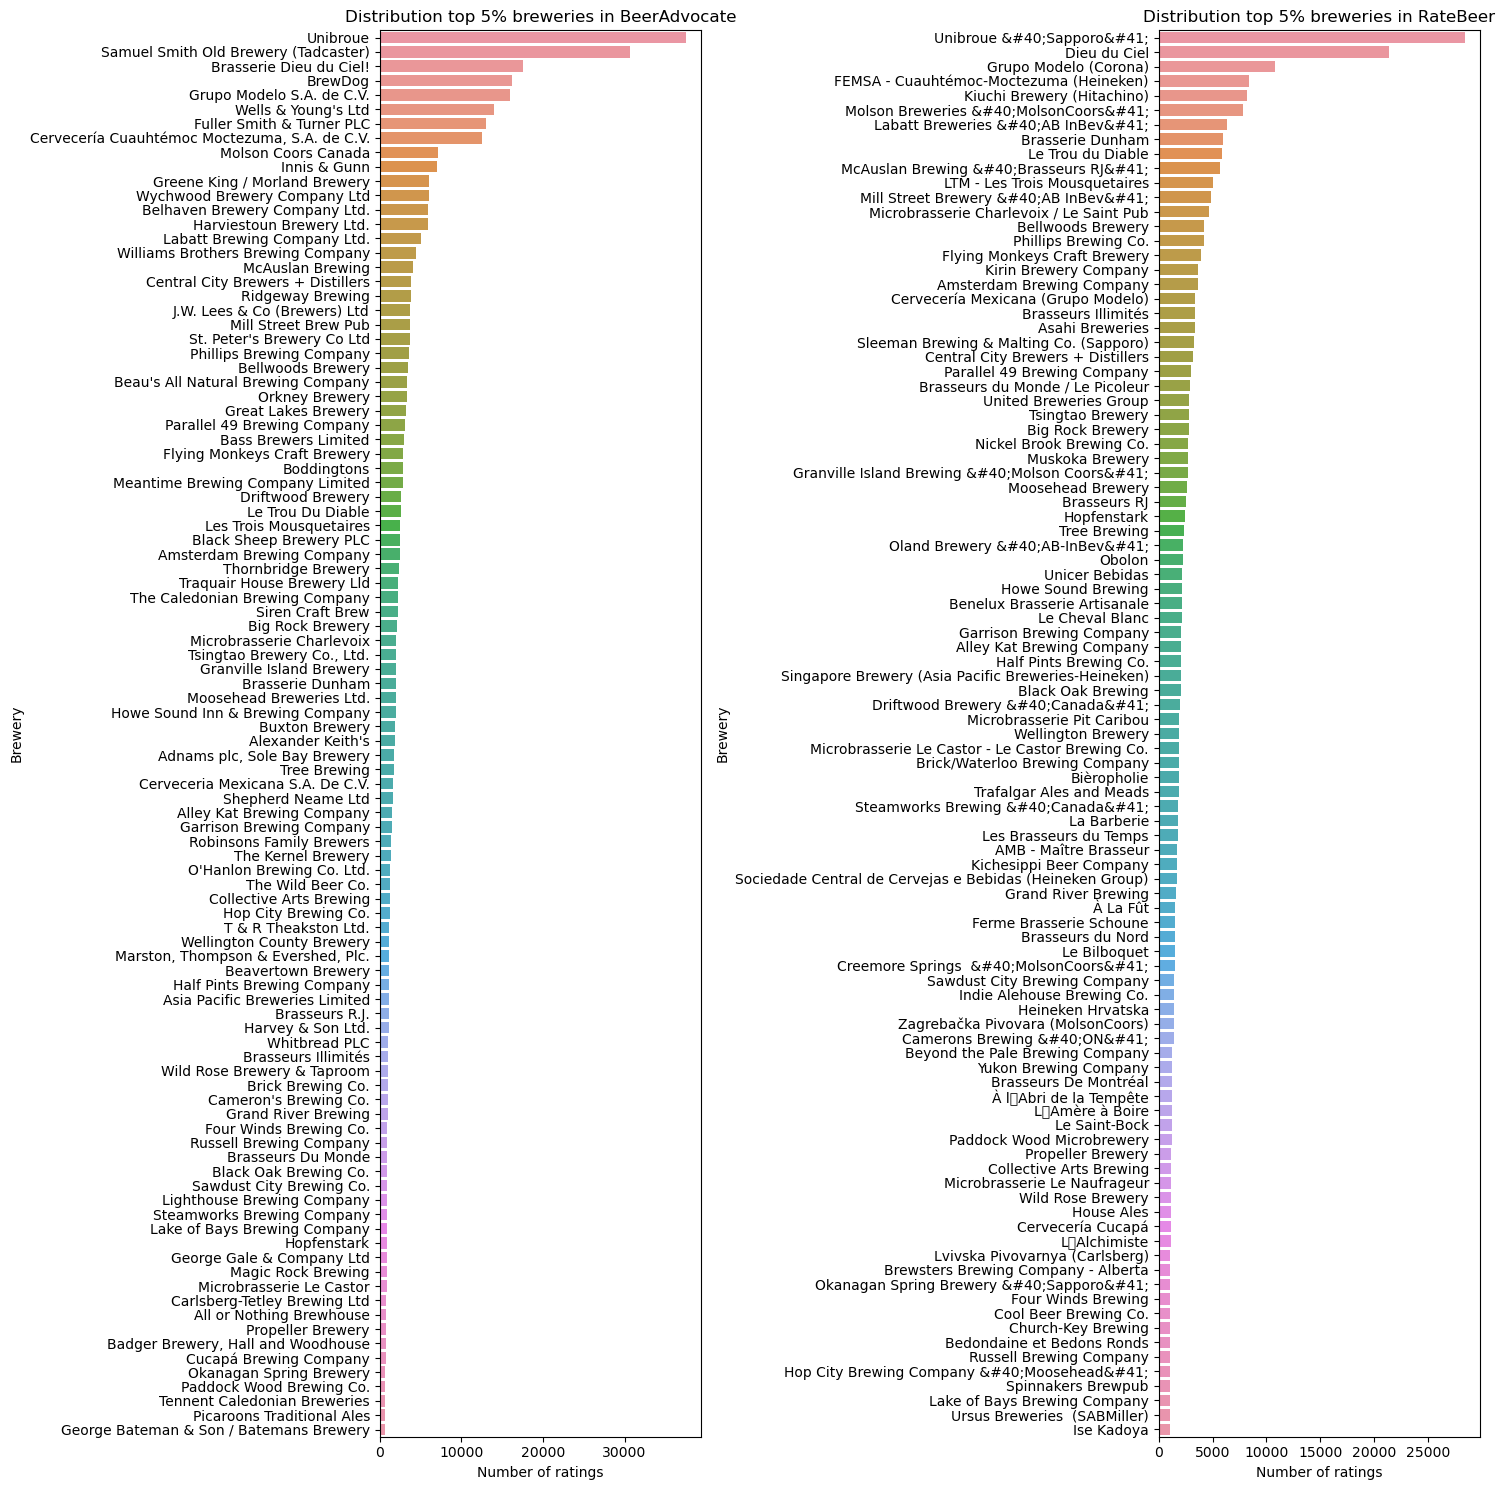

In [23]:
print(f"Number of different breweries in BA : {len(ratings_BA['brewery_id'].unique())}")
print(f"Number of different breweries in RB : {len(ratings_RB['brewery_id'].unique())}")

def filter_topk_breweries(df, k):
    # Find the top k% of breweries most rated
    brewery_count = pd.DataFrame({"count": df.groupby('brewery_name').apply(lambda x: len(x))})
    threshold = brewery_count['count'].quantile(k)
    top_breweries = brewery_count[brewery_count['count'] > threshold].index

    # Filter DataFrame based on the selected brewery names
    df_filtered = df[df['brewery_name'].isin(top_breweries)]
    return df_filtered

ratings_BA_top5_breweries = filter_topk_breweries(ratings_BA, 0.95)
ratings_RB_top5_breweries = filter_topk_breweries(ratings_RB, 0.95)

fig, axs = plt.subplots(1,2, figsize=(15, 15))
sns.countplot(y='brewery_name', data = ratings_BA_top5_breweries, order = ratings_BA_top5_breweries['brewery_name'].value_counts().index, ax = axs[0])
sns.countplot(y='brewery_name', data = ratings_RB_top5_breweries, order = ratings_RB_top5_breweries['brewery_name'].value_counts().index, ax = axs[1])

axs[0].set_title("Distribution top 5% breweries in BeerAdvocate")
axs[1].set_title("Distribution top 5% breweries in RateBeer")

for ax in axs.flat:
    ax.set_xlabel("Number of ratings")
    ax.set_ylabel("Brewery")

plt.tight_layout()
plt.show()

**Style**

Number of different style of beers in BA : 105
Number of different style of beers in RB : 90


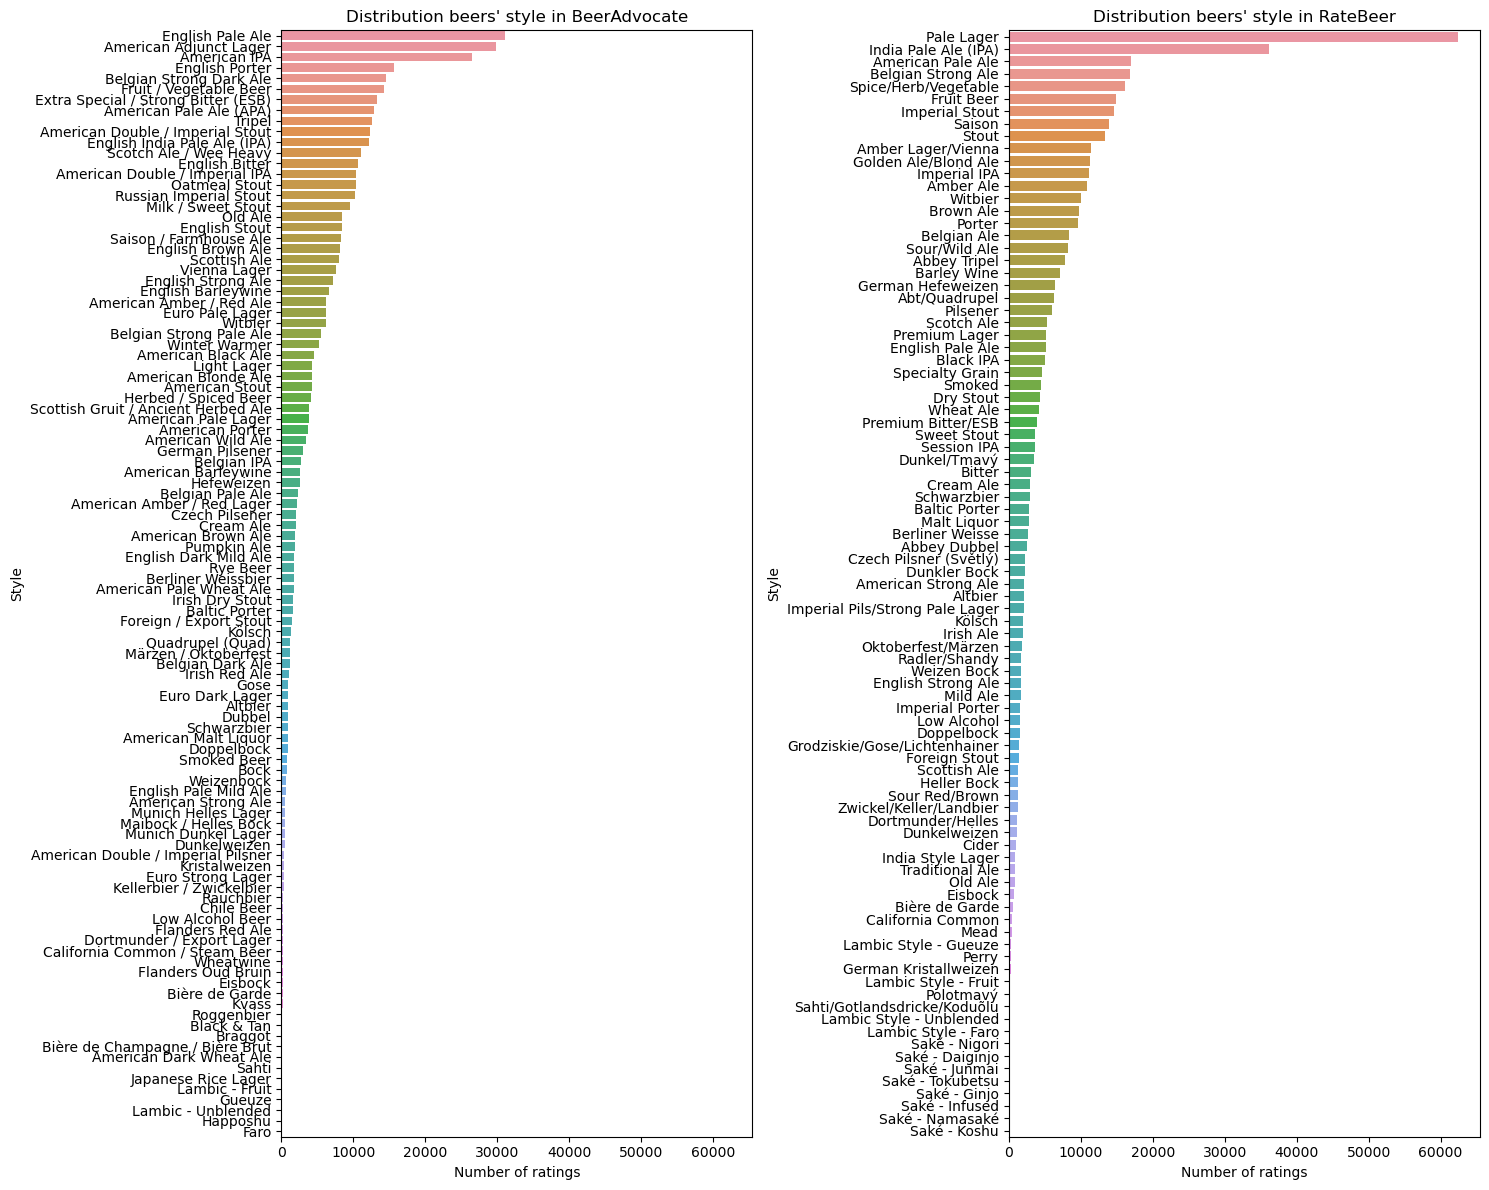

In [24]:
print(f"Number of different style of beers in BA : {len(ratings_BA['style'].unique())}")
print(f"Number of different style of beers in RB : {len(ratings_RB['style'].unique())}")

fig, axs = plt.subplots(1,2, figsize=(15, 12), sharex = True)
sns.countplot(y='style', data=ratings_BA, order = ratings_BA['style'].value_counts().index,ax = axs[0])
sns.countplot(y='style', data=ratings_RB, order = ratings_RB['style'].value_counts().index,ax = axs[1])

axs[0].set_title("Distribution beers' style in BeerAdvocate")
axs[1].set_title("Distribution beers' style in RateBeer")

for ax in axs.flat:
    ax.set_xlabel("Number of ratings")
    ax.set_ylabel("Style")

plt.tight_layout()
plt.show()

In the following cell, we define a function `filter_topk_styles` that will allow us to plot only the styles most represented in the dataset.

In [25]:
def filter_topk_styles(df, k):
    # Find the top k% of breweries most rated
    style_count = pd.DataFrame({"count": df.groupby('style').apply(lambda x: len(x))})
    threshold = style_count['count'].quantile(k)
    top_styles = style_count[style_count['count'] > threshold].index

    # Filter DataFrame based on the selected brewery names
    df_filtered = df[df['style'].isin(top_styles)]
    return df_filtered

### 2. Numerical features

- abv
- appearance
- aroma
- palate
- taste
- overall
- rating

In [26]:
def plot_features(df, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating'] 
    fig, axes = plt.subplots(2, 4, figsize=(15,10))
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        data = df[~df[col].isna()]
        sns.histplot(data=data[col], bins=50, ax=ax) 
    fig.suptitle(title)
    fig.tight_layout()
    return fig

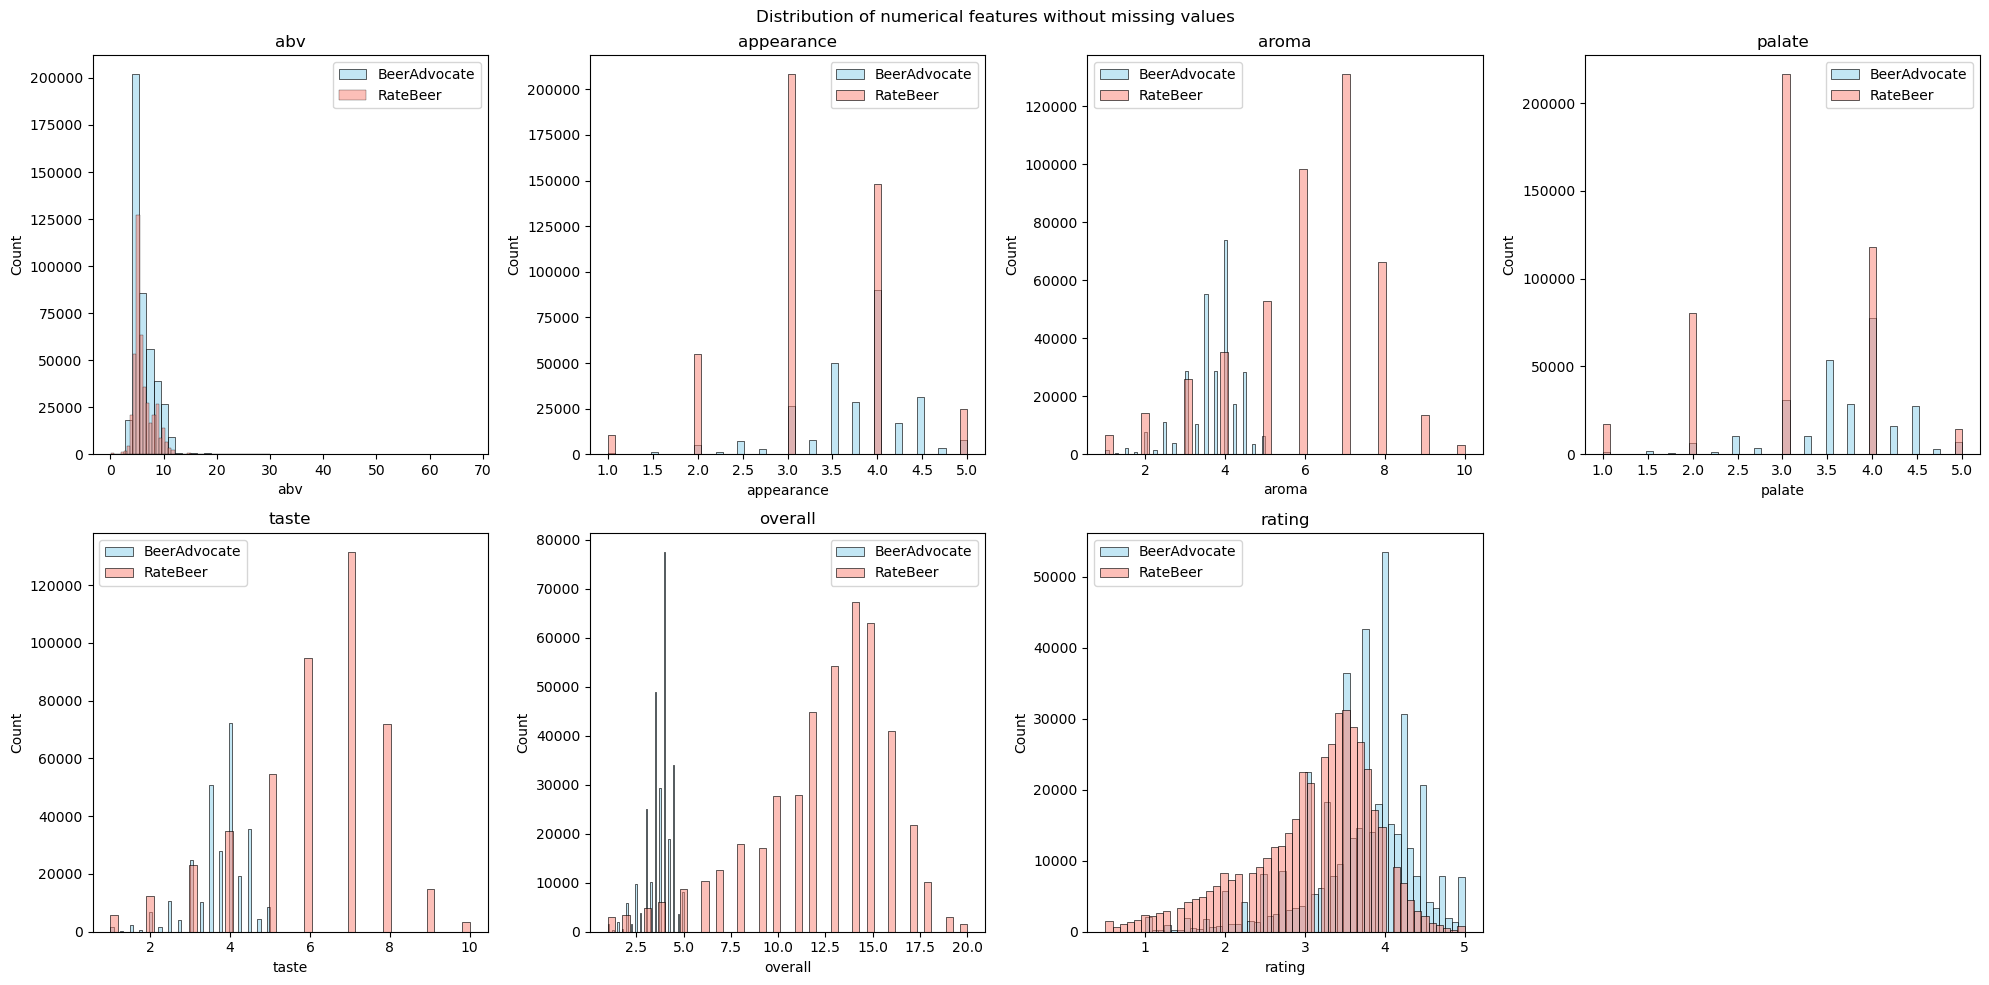

In [29]:
def plot_features(df1, df2, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
    fig, axes = plt.subplots(2, 4, figsize=(20,10))
    fig.delaxes(axes[1, 3])
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        sns.histplot(data=df1[~df1[col].isna()], x=col, bins=50, ax=ax, color='skyblue', alpha=0.5, label='BeerAdvocate')
        sns.histplot(data=df2[~df2[col].isna()], x=col, bins=50, ax=ax, color='salmon', alpha=0.5, label='RateBeer')
        ax.set_title(col)
        ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    return fig

fig = plot_features(ratings_BA, ratings_RB, "Distribution of numerical features without missing values")
plt.show()

This mosaique plots highlights the differences in the notation between the two websites. Especially in teh appearance and palate categories: RateBeer users are not allowed to put non integer values. This is not the case for BeerAdvocate users. This is why the distribution of the RateBeer ratings is more discrete than the BeerAdvocate one.
One another side, the overall ratings in RateBeer and BeerAdvocate are not on the same scales: 5-scale for BeerAdvocate and 20-scale for RateBeer.

Later on in this notebooks, the values will be normalized for better comparison.

- Scores - styles

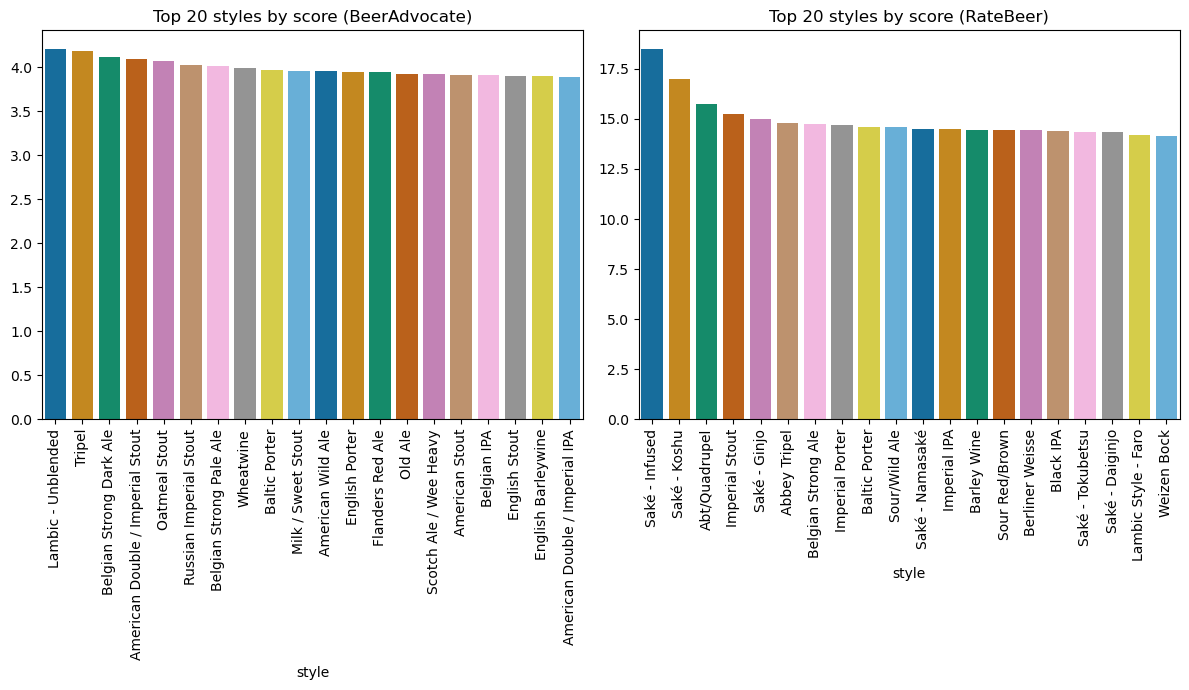

In [30]:
plt.figure(figsize=(12, 7))

# Best rated styles for BeerAdvocate
plt.subplot(1, 2, 1)
sns.barplot(x=ratings_BA.groupby('style')['overall'].mean().sort_values(ascending=False).head(20).index,
            y=ratings_BA.groupby('style')['overall'].mean().sort_values(ascending=False).head(20).values, palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)
plt.title('Top 20 styles by score (BeerAdvocate)')

# Best rated styles for RateBeer 
plt.subplot(1, 2, 2)
sns.barplot(x=ratings_RB.groupby('style')['overall'].mean().sort_values(ascending=False).head(20).index,
            y=ratings_RB.groupby('style')['overall'].mean().sort_values(ascending=False).head(20).values, palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)
plt.title('Top 20 styles by score (RateBeer)')

plt.tight_layout()
plt.show()

Plotting the beer styles with the best average score gives a good idea of the top styles and will be useful for the final visualisation of the best breweries in the world with the best styles.

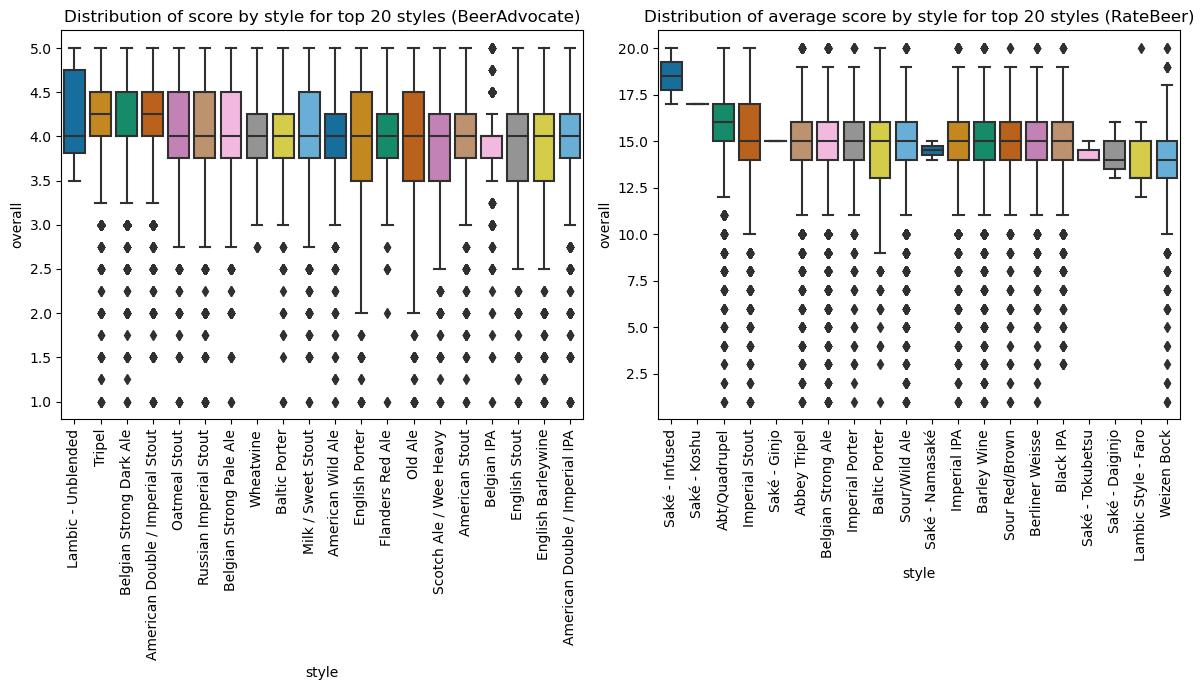

In [31]:
# Calculate the average score for each style and take the top 20 for RateBeer

def style_order_fcn(beers_df):
    style_order = beers_df.groupby('style')['overall'].mean().sort_values(ascending=False).head(20).index
    return style_order

style_order_BA = style_order_fcn(ratings_BA)
style_order_RB = style_order_fcn(ratings_RB)

# Create the boxplots
plt.figure(figsize=(12, 7))

# Create the boxplot for BeerAdvocate
plt.subplot(1, 2, 1)
sns.boxplot(x='style', y='overall', data=ratings_BA[ratings_BA['style'].isin(style_order_BA)], order=style_order_BA, palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)
plt.title('Distribution of score by style for top 20 styles (BeerAdvocate)')

# Create the boxplot for RateBeer
plt.subplot(1, 2, 2)
sns.boxplot(x='style', y='overall', data=ratings_RB[ratings_RB['style'].isin(style_order_RB)], order=style_order_RB, palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)
plt.title('Distribution of average score by style for top 20 styles (RateBeer)')
plt.tight_layout()
plt.show()

To go deeper in the analysis of the top styles these boxplots show the repartition of the scores. These informations are useful to get a real idea of the overall score distribution.

- Scores - breweries

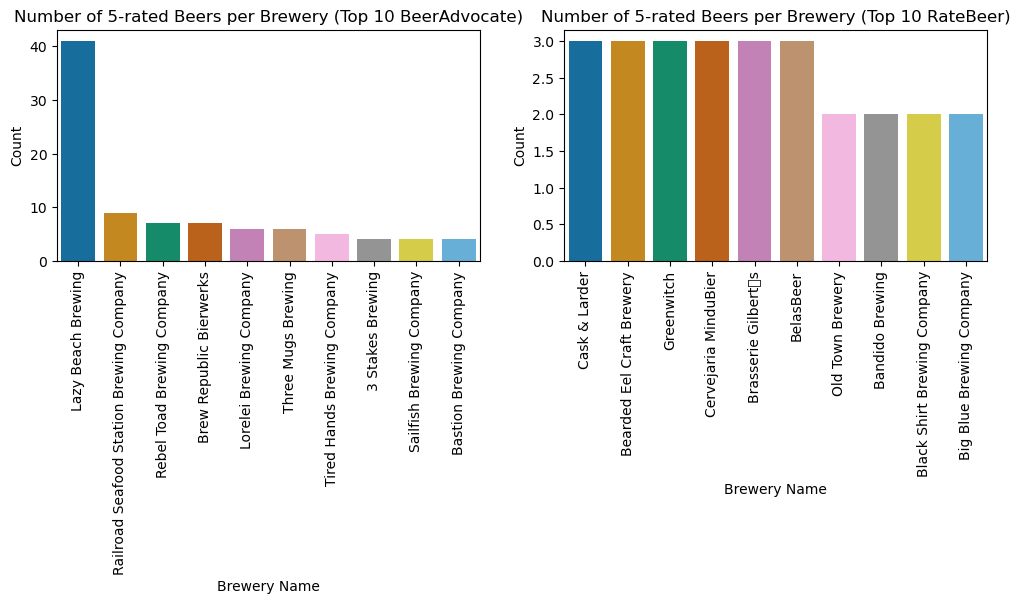

In [32]:
def top_breweries_fcn(beers_df):
    #Identify breweries with most 5 rated beers for RateBeer
    beer_score_5 = beers_df[beers_df['avg_computed'] == 5]
    # Count the occurrences of each brewery
    brewery_counts = beer_score_5['brewery_name'].value_counts().nlargest(10)

    # Create a DataFrame with the top 10 breweries and their counts
    top_breweries = pd.DataFrame({'brewery_name': brewery_counts.index, 'count': brewery_counts.values})
    return top_breweries, beer_score_5

top_breweries_BA, _ = top_breweries_fcn(beers_BA)
top_breweries_RB, _ = top_breweries_fcn(beers_RB)

_ , beer_score_5_BA = top_breweries_fcn(beers_BA)
_ , beer_score_5_RB = top_breweries_fcn(beers_RB)

# Create the barplots
plt.figure(figsize=(12, 3))

# Create a barplot for BeerAdvocate
plt.subplot(1, 2, 1)
sns.barplot(x='brewery_name', y='count', data=top_breweries_BA, palette=sns.color_palette("colorblind"))
plt.title('Number of 5-rated Beers per Brewery (Top 10 BeerAdvocate)')
plt.xlabel('Brewery Name')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Create a barplot for RateBeer
plt.subplot(1, 2, 2)
sns.barplot(x='brewery_name', y='count', data=top_breweries_RB, palette=sns.color_palette("colorblind"))
plt.title('Number of 5-rated Beers per Brewery (Top 10 RateBeer)')
plt.xlabel('Brewery Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Here, the "breweries" and "beers" dataframes were used instead of rating because the number of five rated beers is normalized by the number of beers per brewery in the next section.
The selection of the breweries with the best number of five rated beers goes along with the idea of finding the best breweries in the world.

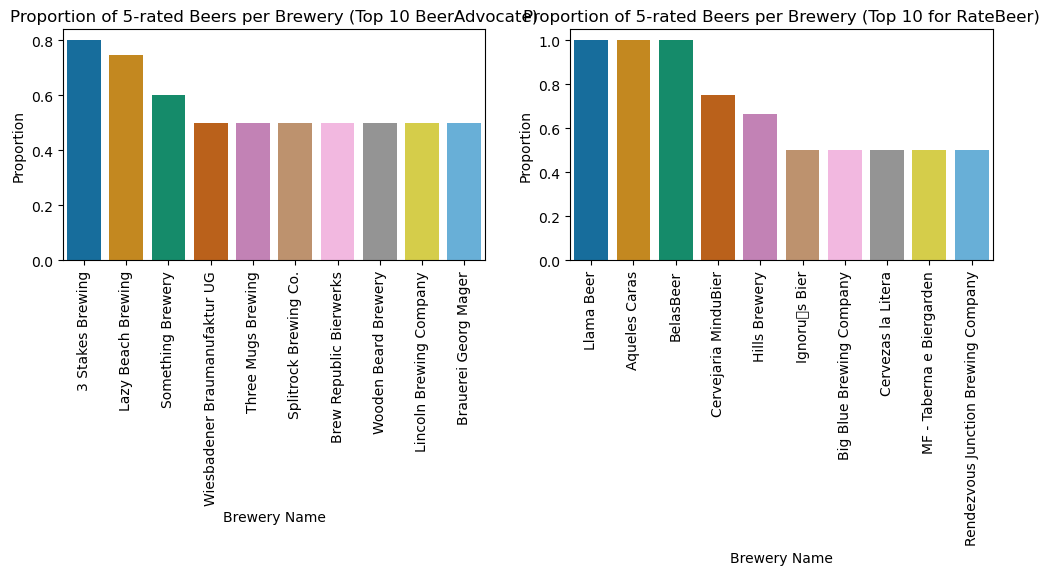

In [33]:
def top_10_proportion(breweries_df, beer_score_5):
    # Create dataframe for breweries with 5 rated beers
    breweries_5 = breweries_df[breweries_df['id'].isin(beer_score_5['brewery_id'])]
    breweries_5.rename(columns={'name': 'brewery_name'}, inplace=True)

    # Isolate brewery infos 
    brewery_counts_all = beer_score_5['brewery_name'].value_counts()
    brewery_count_df = pd.DataFrame({'brewery_name': brewery_counts_all.index, 'count': brewery_counts_all.values})

    # Determining the proportion of 5 rated beers
    # Merge DataFrames on the 'brewery_name' column
    proportion_of_5_df = pd.merge(breweries_5, brewery_count_df, on='brewery_name', how='inner')

    # Exclude breweries with less than 2 beers to get meaningful proportions
    proportion_of_5_df = proportion_of_5_df[proportion_of_5_df['nbr_beers'] >= 2]

    # Perform division
    proportion_of_5_df['proportion'] = proportion_of_5_df['count'] / proportion_of_5_df['nbr_beers']

    # Taking Top 10 breweries
    Top_10_breweries = proportion_of_5_df.sort_values('proportion', ascending=False).head(10)
    
    return Top_10_breweries

Top_10_breweries_BA = top_10_proportion(breweries_BA, beer_score_5_BA)
Top_10_breweries_RB = top_10_proportion(breweries_RB, beer_score_5_RB)

# Create a histogram of the top 10 breweries with the most 5 rated beers ordered by proportion
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
sns.barplot(x='brewery_name', y='proportion', data=Top_10_breweries_BA, palette=sns.color_palette("colorblind"))
plt.title('Proportion of 5-rated Beers per Brewery (Top 10 BeerAdvocate)')
plt.xlabel('Brewery Name')
plt.xticks(rotation=90)
plt.ylabel('Proportion')

plt.subplot(1, 2, 2)
sns.barplot(x='brewery_name', y='proportion', data=Top_10_breweries_RB, palette=sns.color_palette("colorblind"))
plt.title('Proportion of 5-rated Beers per Brewery (Top 10 for RateBeer)')
plt.xlabel('Brewery Name')
plt.xticks(rotation=90)
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()

This plot, shows the proportion of 5 rated beers for the best breweries. Breweries with only one beer were filtered to get more relevant proportions.
On this plot it seems that the data from BeerAdvocate is more representative given that the proportions displayed are not just equal to one.

- Correlations

In [34]:
def calculate_correlations(df1, df2):
        """
        Calculates the correlation between all numerical features.
        
        Parameters
        ----------
        df1 : DataFrame
                First dataframe containing all data
        df2 : DataFrame
                Second dataframe containing all data

        Returns
        -------
        None
        """
        # Extract numerical columns from the first dataframe and calculate correlation
        numerical_cols1 = df1.select_dtypes(include=['float64', 'int64']).columns
        corr1 = df1[numerical_cols1].corr()

        # Extract numerical columns from the second dataframe and calculate correlation
        numerical_cols2 = df2.select_dtypes(include=['float64', 'int64']).columns
        corr2 = df2[numerical_cols2].corr()

        # Create subplots for heatmaps of correlations between numerical features in both dataframes
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        sns.heatmap(corr1, annot=True, ax=axes[0])
        sns.heatmap(corr2, annot=True, ax=axes[1])
        
        # Set titles for the subplots
        axes[0].set_title('Correlation between numerical features in BeerAdvocate')
        axes[1].set_title('Correlation between numerical features in RateBeer')
        plt.show()

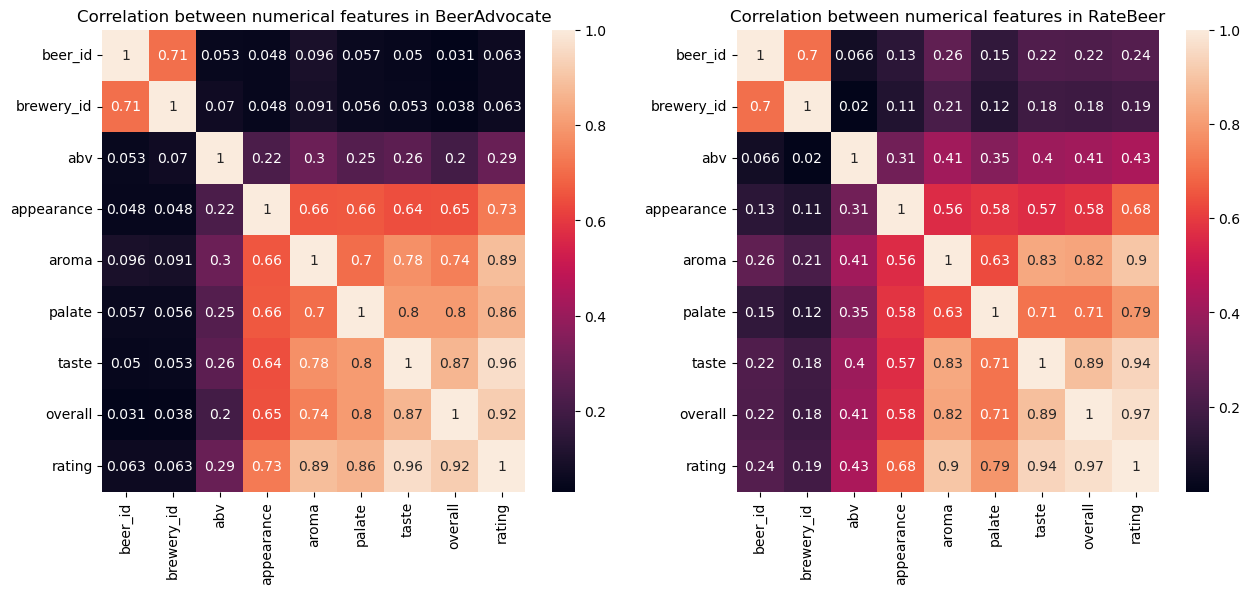

In [35]:
calculate_correlations(ratings_BA, ratings_RB)

Performing correlation help having a better understanding of the beer rating. One can note that the most relevant part is the lower right corner of the correlation matrix, as the correlation between beer_id and brewery_id might not tell us much. The lower right areas of the matrices look warmer, translating a high correlation between features. Looking a the rating, from the matrices one can see that a beer rater tends to put high rate scores to tastier, and more complex beers.

On difference is that between the 2 websites the correlations are different specially in the appearance where BeerAdvocate users look like they are more focused towards it when rating the beverage.

### 3. Textual reviews

**Number of words in textual reviews**

In [36]:
mean_words_BA = np.mean(ratings_BA["text"].apply(lambda row : len(str(row))))
mean_words_RB = np.mean(ratings_RB["text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BeerAdvocate : {mean_words_BA}")
print(f"Average number of words in textual reviews of RareBeer : {mean_words_RB}")

Average number of words in textual reviews of BeerAdvocate : 290.318211995796
Average number of words in textual reviews of RareBeer : 308.98221555747045


**N most common words in textual reviews**

In [37]:
def get_top_n_i_gram(corpus, i, n=None):
    """
    Extracts the top 'n' n-grams from a corpus.
    
    Parameters
    ----------
    corpus : Series or list
        Contains text data.
    i : int
        Specifies the 'i' in n-grams.
    n : int, optional
        Specifies the number of top n-grams to return. Default is None.

    Returns
    -------
    words_freq : list
        Contains tuples of n-grams and their frequencies.
    """
    # Drop rows with NaN values in the 'text' column
    corpus = corpus.dropna()
    # Fit CountVectorizer with specified n-gram range
    vec = CountVectorizer(ngram_range=(i,i)).fit(corpus)
    # Transform the corpus into a bag of words
    bag_of_words = vec.transform(corpus)
    # Sum the occurrences of each word across the corpus
    sum_words = bag_of_words.sum(axis=0) 
    # Create a list of tuples containing words and their frequencies
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort the list by frequency in descending order
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [38]:
# can take 5-7 min to run
N = 20

# BeerAdvocate
common_unigrams_BA = get_top_n_i_gram(ratings_BA['text'], 1, N)
common_bigrams_BA = get_top_n_i_gram(ratings_BA['text'], 2, N)
common_trigrams_BA = get_top_n_i_gram(ratings_BA['text'], 3, N)
# Rate Beer
common_unigrams_RB = get_top_n_i_gram(ratings_RB['text'], 1, N)
common_bigrams_RB = get_top_n_i_gram(ratings_RB['text'], 2, N)
common_trigrams_RB = get_top_n_i_gram(ratings_RB['text'], 3, N)

In [39]:
def plot_ngrams(common_unigrams, common_bigrams, common_trigrams):
    # Creating subplots
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    # Subplot 1: Common Unigrams
    df1 = pd.DataFrame(common_unigrams, columns=['Review Text', 'count'])
    df1.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[0])
    axes[0].set_title(f'Top {N} words in reviews')

    # Subplot 2: Common Bigrams
    df2 = pd.DataFrame(common_bigrams, columns=['Review Text', 'count'])
    df2.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[1])
    axes[1].set_title(f'Top {N} bigrams in reviews')

    # Subplot 3: Common Trigrams
    df3 = pd.DataFrame(common_trigrams, columns=['Review Text', 'count'])
    df3.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[2])
    axes[2].set_title(f'Top {N} trigrams in reviews')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

##### BeerAdvocate

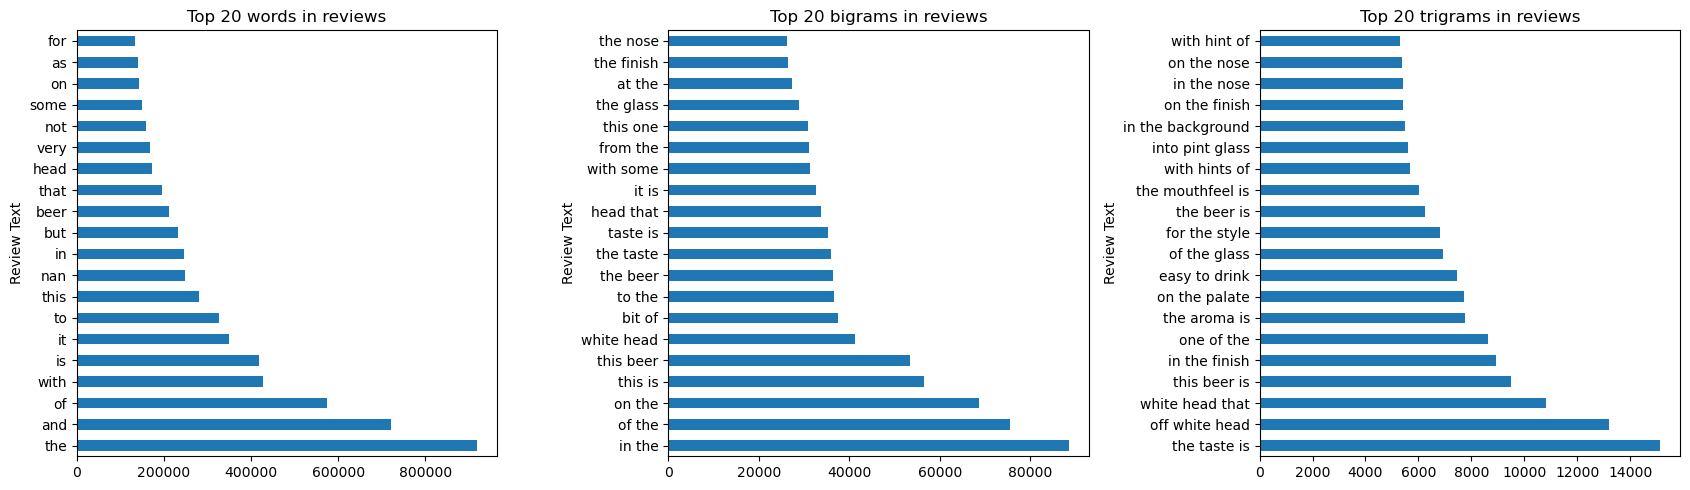

##### RateBeer

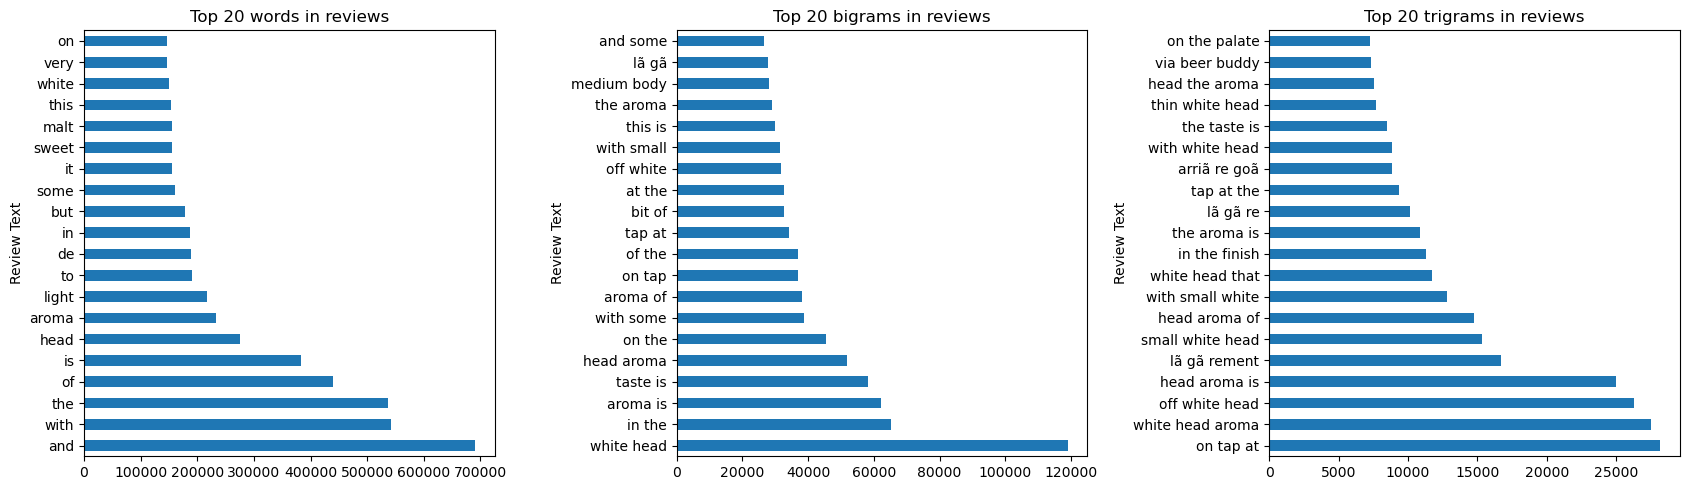

In [40]:
display(Markdown("##### BeerAdvocate"))
plot_ngrams(common_unigrams_BA, common_bigrams_BA, common_trigrams_BA)
display(Markdown("##### RateBeer"))
plot_ngrams(common_unigrams_RB, common_bigrams_RB, common_trigrams_RB)

With these plots, we observe that there are a lot of words not interesting to describe a beer but just useful to write a sentence (eg: and, with,the...). This is what we call stopwords. To have a relevant analysis in the next part we will process the sentences.  

---

## Data preprocessing

### Transformation

- Standardization of numerical features

In [41]:
def normalize_numerical_data(df):
    """
    Normalizes the numerical features of the DataFrame.
    
    Parameters
    ----------
    df : DataFrame
        Containing all data

    Returns
    -------
    df : DataFrame
        Containing all data with normalized numerical features.
                
    """
    df2 = df.copy()
    numerical = df2._get_numeric_data().columns
    for col in numerical:
        df2[col] = (df2[col] - df2[col].mean()) / df2[col].std()
    return df2

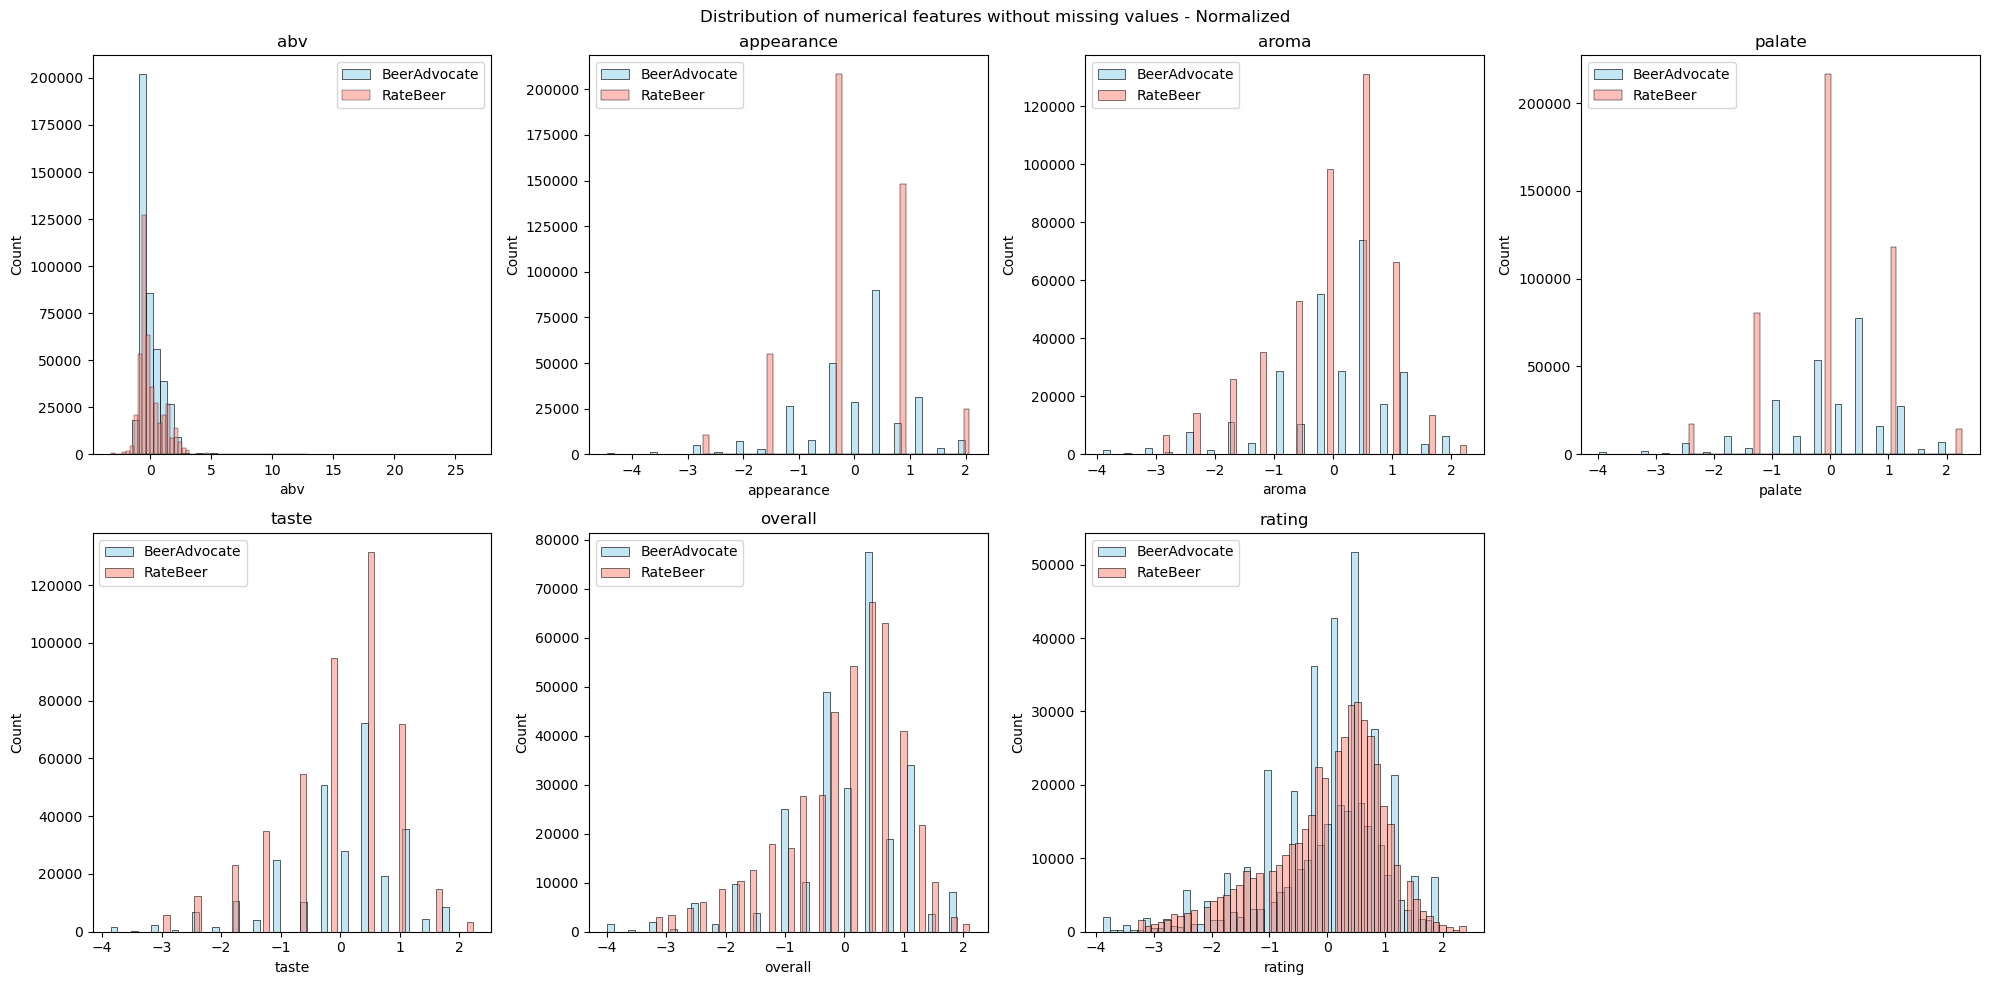

In [42]:
fig = plot_features(normalize_numerical_data(ratings_BA), normalize_numerical_data(ratings_RB), "Distribution of numerical features without missing values - Normalized")

After standardization, the distributions of the different features are made comparable across the 2 websites.

The overall scores from the 2 websites follow a very similar distribution although in the beginning they were not on the same scale. This shows that we have enough colledted data.

- **date** feature

The date feature is hereafter reformated to be processed more easily.

In [43]:
def add_rating_month_feature(df):
    """
    Adds a 'month' feature to the DataFrame based on the 'date' column.
    
    Parameters
    ----------
    df : DataFrame
        Contains data including a 'date' column.

    Returns
    -------
    df_m : DataFrame
        Contains the original data with an additional 'month' feature.
    """
    # Create a copy of the DataFrame
    df_m = df.copy()
    # Conversion of date feature from timestamp to text date
    pd.to_numeric(df_m['date'], errors='coerce', downcast='integer')
    # Convert 'date' to datetime and extract the date
    df_m.date = ratings_BA.date.apply(lambda d: pd.to_datetime(d, unit='s'))
    df_m['date'] = df_m['date'].dt.date
    df_m.head(2)

    # Extract the month from the 'date' column and add it as a new feature 'month'
    df_m['month'] = pd.to_datetime(df_m['date']).dt.month

    return df_m

In [44]:
ratings_BA_monthly = add_rating_month_feature(ratings_BA)
ratings_RB_monthly = add_rating_month_feature(ratings_RB)

- **text** feature

In [45]:
nltk.download('words')
nltk.download('stopwords') # Download NLTK stopwords
nltk.download('wordnet')   # Lemmatization
nltk.download('words')
english_words=set(words.words())
# Get the set of English stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


As mentioned previously to have a relevant analysis, we need to transform review texts. To facilitate the comparison we have first remove punctuation, capital letters and remove the stopwords we have talked about. Another function lemmatize the senctences that means "grouping together the inflected forms of a word so they can be analysed as a single item" (Wikipedia definition). For example drinking will be rewrite drink.
We have also removed not english-words to facilitate the analysis and the polarity sentiment. Indeed, in the EDA part we could see that there are different languages in the reviews.

In [46]:
def preprocess_sentences(df):    
    # Remove rows with no sentences (NaN values)
    df = df[~df['text'].isnull()]

    # Remove punctuation and convert to lowercase
    def clean_text(sentence):
        translator = str.maketrans('', '', string.punctuation)
        cleaned = sentence.translate(translator).lower()
        return cleaned

    # Function to lemmatize 
    def lemmatize_text(sentence):
        tokens = word_tokenize(sentence)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)

    # Function to remove stop words
    def remove_stopwords(sentence):
        tokens = word_tokenize(sentence)
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
        return ' '.join(filtered_tokens)

    # Function to remove non-english words
    def keep_only_english(sentence):
        return " ".join(w for w in nltk.wordpunct_tokenize(sentence) if w.lower() in english_words or not w.isalpha())
    
    df['cleaned_text'] = df['text'].apply(clean_text)
    df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)
    df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
    df['cleaned_text'] = df['cleaned_text'].apply(keep_only_english)
    
    return df

def compute_top_words(df):
    # Split the sentences into individual words
    all_words = ' '.join(df['cleaned_text']).split()

    # Count word occurrences
    word_counts = Counter(all_words)

    # Get the top 20 most common words
    top_words = word_counts.most_common(20)

    # Convert to DataFrame for easy plotting
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
    
    return top_words_df

In [48]:
# can take 6-8 min to run on all the sentences
ratings_BA_cleaned = preprocess_sentences(ratings_BA)
ratings_RB_cleaned = preprocess_sentences(ratings_RB)

# correction to remove missing sentences
ratings_BA_cleaned = ratings_BA_cleaned[ratings_BA_cleaned['cleaned_text'] != 'nan']
ratings_RB_cleaned = ratings_RB_cleaned[ratings_RB_cleaned['cleaned_text'] != 'nan']

In [49]:
# Before preprocessing of the sentences
print("Before cleaning")
mean_words_BA = np.mean(ratings_BA["text"].apply(lambda row : len(str(row))))
mean_words_RB = np.mean(ratings_RB["text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BA : {mean_words_BA}")
print(f"Average number of words in textual reviews of RB : {mean_words_RB}")

# After preprocessing of the sentences
print("\nAfter cleaning")
mean_words_BA = np.mean(ratings_BA_cleaned["cleaned_text"].apply(lambda row : len(str(row))))
mean_words_RB = np.mean(ratings_RB_cleaned["cleaned_text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BA : {mean_words_BA}")
print(f"Average number of words in textual reviews of RB : {mean_words_RB}")

Before cleaning
Average number of words in textual reviews of BA : 290.318211995796
Average number of words in textual reviews of RB : 308.98221555747045

After cleaning
Average number of words in textual reviews of BA : 164.9503321171087
Average number of words in textual reviews of RB : 183.04401123824772


Top N most common words after preprocessing

In [50]:
# can take 5-7 min to run on all the sentences
N = 20

# BeerAdvocate
common_unigrams_BA = get_top_n_i_gram(ratings_BA_cleaned['cleaned_text'], 1, N)
common_bigrams_BA = get_top_n_i_gram(ratings_BA_cleaned['cleaned_text'], 2, N)
common_trigrams_BA = get_top_n_i_gram(ratings_BA_cleaned['cleaned_text'], 3, N)
# Rate Beer
common_unigrams_RB = get_top_n_i_gram(ratings_RB_cleaned['cleaned_text'], 1, N)
common_bigrams_RB = get_top_n_i_gram(ratings_RB_cleaned['cleaned_text'], 2, N)
common_trigrams_RB = get_top_n_i_gram(ratings_RB_cleaned['cleaned_text'], 3, N)

In [51]:
def plot_ngrams(common_unigrams, common_bigrams, common_trigrams):
    # Creating subplots
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    # Subplot 1: Common Unigrams
    df1 = pd.DataFrame(common_unigrams, columns=['Review Text', 'count'])
    df1.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[0])
    axes[0].set_title(f'Top {N} words in reviews')

    # Subplot 2: Common Bigrams
    df2 = pd.DataFrame(common_bigrams, columns=['Review Text', 'count'])
    df2.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[1])
    axes[1].set_title(f'Top {N} bigrams in reviews')

    # Subplot 3: Common Trigrams
    df3 = pd.DataFrame(common_trigrams, columns=['Review Text', 'count'])
    df3.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[2])
    axes[2].set_title(f'Top {N} trigrams in reviews')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

##### BeerAdvocate

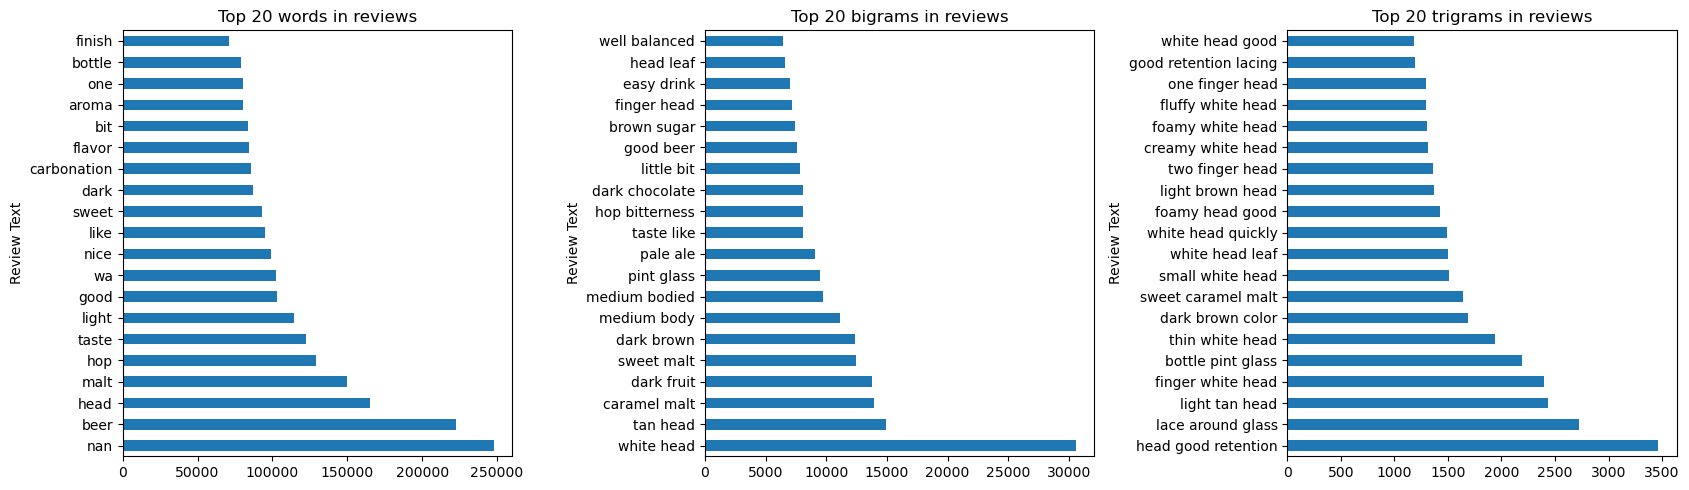

##### RateBeer

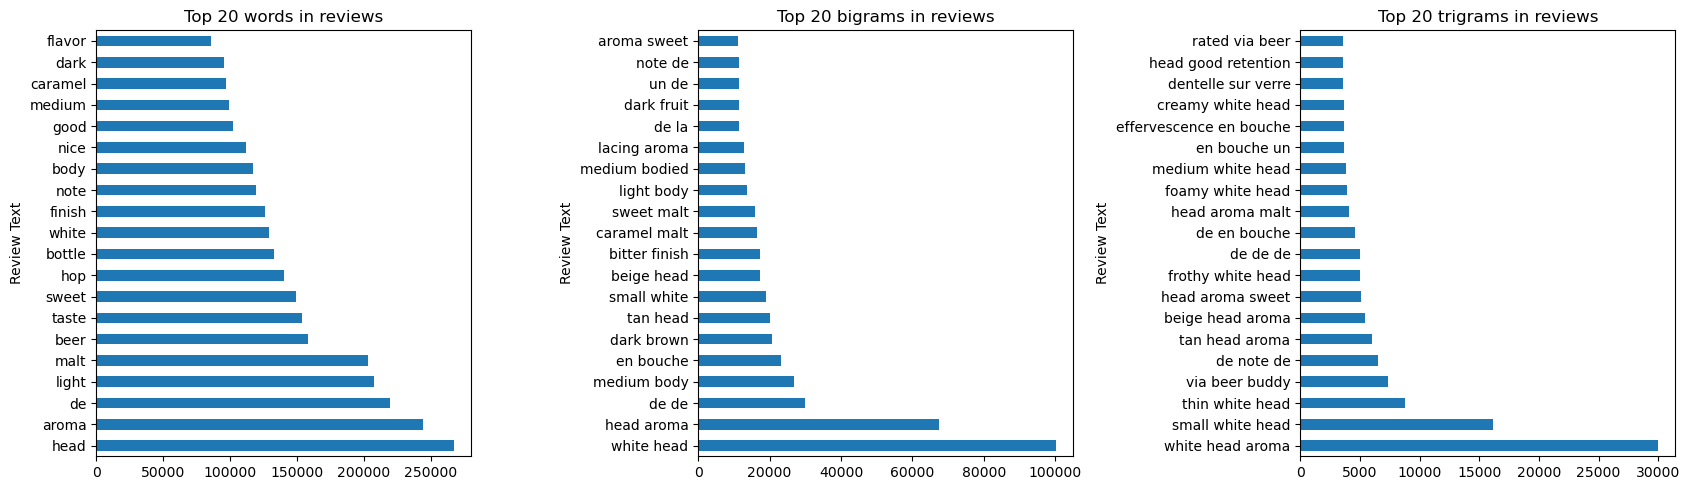

In [52]:
display(Markdown("##### BeerAdvocate"))
plot_ngrams(common_unigrams_BA, common_bigrams_BA, common_trigrams_BA)
display(Markdown("##### RateBeer"))
plot_ngrams(common_unigrams_RB, common_bigrams_RB, common_trigrams_RB)

We see that some words are very recurring like aroma, taste, sweet both in words and expressions. This analysis can be linked to the correlation matrix where we can see that the rating is correlated to these aspects in the numerical ratings. So these are clearly most important aspects in the way to rate beers.

---

## Feasibility check of project's methods

This part aims at verifying if our project plans are reasonable and sound. We will thus check that the ratings and the sentiment analysis (such as polarity and subjectivity) are not homogeneous across breweries, styles and by extension to users. It will thus support our idea to correct the ratings based on the reviews.

### 1. Ratings distribution

**Ratings intervals**

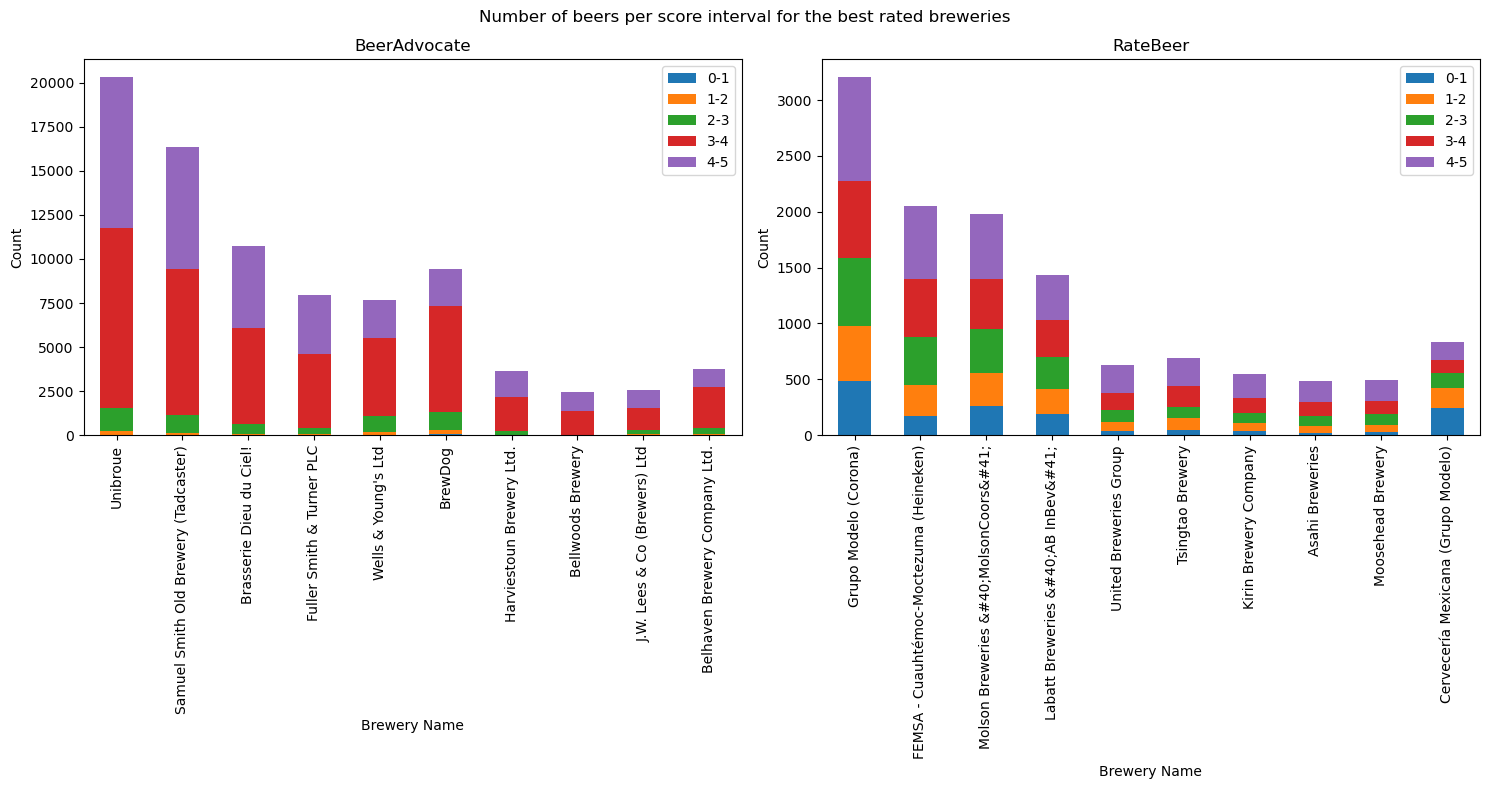

In [53]:
# Count the number of beers per rating interval
def count_beers_per_rating_interval(beers_df):
    beers_score =[]
    brewery_counts = []
    for i in range(5):
        beers_score.append(beers_df[(i < beers_df['overall']) & (beers_df['overall'] <= i+1)])
        brewery_counts.append(beers_score[i]['brewery_name'].value_counts().sort_index())
    return brewery_counts

breweries_rating_counts_BA = count_beers_per_rating_interval(ratings_BA)
breweries_rating_counts_RB = count_beers_per_rating_interval(ratings_RB)

# Dataframe with the number of beers per rating interval matched with the brewery name
# Create a dataframe with the different lists in breweries_rating_counts_BA as columns matching in the brewery name for the rows
def breweries_rating_counts(beers_df):
    breweries_rating_counts = pd.concat(count_beers_per_rating_interval(beers_df), axis=1, keys=['0-1', '1-2', '2-3', '3-4', '4-5'])
    breweries_rating_counts.index.name = 'Brewery Name'
    breweries_rating_counts.fillna(0, inplace=True)
    breweries_rating_counts = breweries_rating_counts.astype(int)
    return breweries_rating_counts

df_breweries_rating_counts_BA = breweries_rating_counts(ratings_BA)
df_breweries_rating_counts_RB = breweries_rating_counts(ratings_RB)

# Create a stacked barplot for the number of beers per rating interval for BeerAdvocate
fig, axs = plt.subplots(1,2, figsize=(15, 8))
df_breweries_rating_counts_BA.sort_values(by='4-5', ascending=False).iloc[:10].plot.bar(stacked=True, rot=90, ax = axs[0])
axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Brewery Name')
axs[0].set_ylabel('Count')

# Create a stacked barplot for the number of beers per rating interval for RateBeer
df_breweries_rating_counts_RB.sort_values(by='4-5', ascending=False).iloc[:10].plot.bar(stacked=True, rot=90, ax = axs[1])
axs[1].set_title('RateBeer')
axs[1].set_xlabel('Brewery Name')
axs[1].set_ylabel('Count')
plt.suptitle("Number of beers per score interval for the best rated breweries")
plt.tight_layout()
plt.show()

This stacked barplot represents the number of beers per brewery that has the biggest number of 5 rated beers, the stacked plot is used to show the proportion of beers rated in the different intervals of score. This representation gives a more detailed representation of the distribution of scores per beers for each brewery.

One can see that the ratings are not equally distributed for the same brewery, especially for the breweries from BeerAdvocate. One user very unhappy with a beer from a brewery in BeerAdvocate could thus have a big influence on the average grade of the brewery and its rating could thus be ponderated in the new ranking system we want to implement as part of our research question.

**Ratings in function of the time**

To asses whether the yearly evolution of the tastes changes, the following plot shows the evolution of the average rating per month along the years

In [54]:
def plot_most_rated_beer_style_per_month(df, name):
    """
    Plots the most consumed beer style per month.
    
    Parameters
    ----------
    df : DataFrame
        The input DataFrame to be used for plotting.

    Returns
    -------
    None
                
    """
    # group the data by month and beer style
    df_month_style = df.groupby(['month', 'style']).size().reset_index(name='count')

    # get the most consumed beer style per month
    idx = df_month_style.groupby(['month'])['count'].transform(max) == df_month_style['count']
    df_most_consumed = df_month_style[idx]

    # plot the most consumed beer style per month
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 5))
    sns.barplot(x="month", y="count", hue="style", data=df_most_consumed)
    plt.title("Most rated beer style per month for {}".format(name))
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.show()

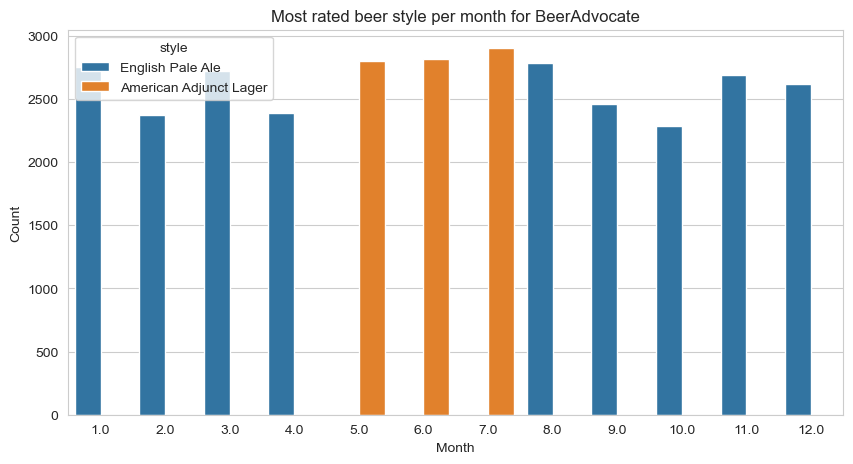

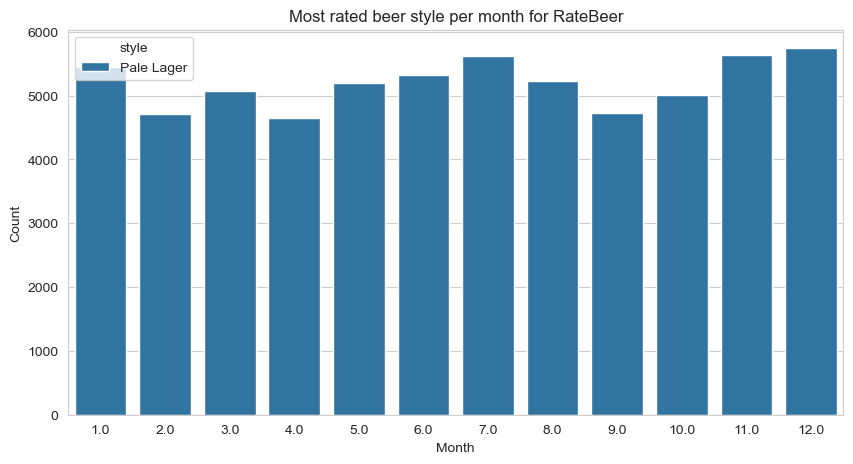

In [55]:
plot_most_rated_beer_style_per_month(ratings_BA_monthly, "BeerAdvocate")
plot_most_rated_beer_style_per_month(ratings_RB_monthly, "RateBeer")

We would like to determine the evolution in time of the prefered beer style in RateBeer and the prefered beer style in function of months. This will be interesting to determine the best beer in function of the season for example.

### 2. Sentiment analysis

In [56]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

**Polarity - subjectivity per website**

BeerAdvocate

In [57]:
# can take 6-8 min to run on all the sentences

# with original text
ratings_BA_cleaned['polarity_text'] = ratings_BA_cleaned['text'].apply(lambda x: getPolarity(x))
ratings_BA_cleaned['subjectivity_text'] = ratings_BA_cleaned['text'].apply(lambda x: getSubjectivity(x))
ratings_BA_cleaned['polarity_Analysis'] = ratings_BA_cleaned['polarity_text'].apply(lambda x: getAnalysis(x))
# with cleaned text
ratings_BA_cleaned['polarity_cleaned_text'] = ratings_BA_cleaned['cleaned_text'].apply(lambda x: getPolarity(x))
ratings_BA_cleaned['subjectivity_cleaned_text'] = ratings_BA_cleaned['cleaned_text'].apply(lambda x: getSubjectivity(x))
ratings_BA_cleaned['cleaned_polarity_Analysis'] = ratings_BA_cleaned['polarity_text'].apply(lambda x: getAnalysis(x))

RateBeer

In [58]:
# can take 8-10 min to run on all the sentences

# with original text
ratings_RB_cleaned['polarity_text'] = ratings_RB_cleaned['text'].apply(lambda x: getPolarity(x))
ratings_RB_cleaned['subjectivity_text'] = ratings_RB_cleaned['text'].apply(lambda x: getSubjectivity(x))
ratings_RB_cleaned['polarity_Analysis'] = ratings_RB_cleaned['polarity_text'].apply(lambda x: getAnalysis(x))
# with cleaned text
ratings_RB_cleaned['polarity_cleaned_text'] = ratings_RB_cleaned['cleaned_text'].apply(lambda x: getPolarity(x))
ratings_RB_cleaned['subjectivity_cleaned_text'] = ratings_RB_cleaned['cleaned_text'].apply(lambda x: getSubjectivity(x))
ratings_RB_cleaned['cleaned_polarity_Analysis'] = ratings_RB_cleaned['polarity_text'].apply(lambda x: getAnalysis(x))

In [80]:
display(ratings_BA_cleaned.head(2), ratings_RB_cleaned.head(2))

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,rating,text,review,cleaned_text,polarity_text,subjectivity_text,polarity_Analysis,polarity_cleaned_text,subjectivity_cleaned_text,cleaned_polarity_Analysis
273843,Solstice D'été Aux Cerises,73716.0,Brasserie Dieu du Ciel!,1141.0,Berliner Weissbier,6.5,1444644000,hopsolutely,hopsolutely.513175,4.0,...,3.9,Enjoying with thanks to Phyl21ca.Rarely does a...,True,enjoying thanks phyl21cararely doe bottle embo...,0.266667,0.487500,Positive,0.268182,0.509091,Positive
169417,O'Hanlons Organic Rye,9123.0,O'Hanlon Brewing Co. Ltd.,1533.0,Rye Beer,5.0,1214733600,aerozeppl,aerozeppl.101084,3.0,...,3.1,A: 2 Finger pour. White head with some piting....,True,2 finger pour white head lacing ha bottle cond...,0.081818,0.385152,Positive,-0.012500,0.346667,Positive


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,overall,rating,text,cleaned_text,polarity_text,subjectivity_text,polarity_Analysis,polarity_cleaned_text,subjectivity_cleaned_text,cleaned_polarity_Analysis
262500,Brew Brothers Prairie Berry Ale,21927.0,Brew Brothers Brewing &#40;Alberta&#41;,3033.0,Fruit Beer,5.5,1044615600,presario,5348,3.0,...,13.0,3.2,Big blue 1L bottle. Very loud pop announced t...,big blue 1l bottle loud pop office wa beer tim...,0.130923,0.577381,Positive,0.11994,0.552381,Positive
39881,Ed Hardy Premium Beer,110849.0,Cervecería Mexicana (Grupo Modelo),5973.0,Pale Lager,4.6,1281520800,Cajun,47922,2.0,...,5.0,1.6,Tasting - Gulf Brew 2010 - Pale amber white he...,tasting gulf brew 2010 pale amber white head n...,-0.042000,0.176000,Negative,-0.05250,0.220000,Negative


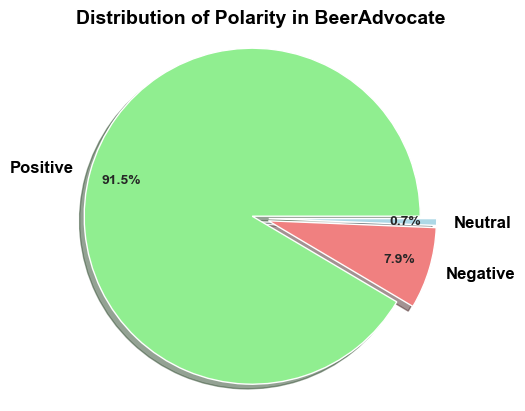

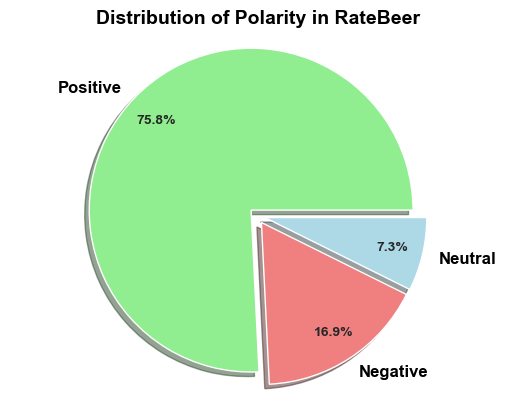

In [85]:
def plot_pie_chart(df, title):
    polarity_counts = df['polarity_Analysis'].value_counts()

    labels = polarity_counts.index
    sizes = polarity_counts.values
    myexplode=[0.05, 0.05, 0.05]
    category_color = {'Positive': 'lightgreen', 'Neutral': 'lightblue', 'Negative': 'lightcoral'}
    
    colors = [category_color[label] for label in labels]
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, explode=myexplode, colors= colors, autopct='%1.1f%%', startangle=0, pctdistance=0.81, shadow=True)

    fig.patch.set_facecolor('none')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Customize the appearance of labels and autopct values
    plt.setp(texts, fontsize=12, fontweight='bold', color= 'black')
    plt.setp(autotexts, fontsize=10, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', color='black')
    plt.show()

plot_pie_chart(ratings_BA_cleaned, 'Distribution of Polarity in BeerAdvocate')
plot_pie_chart(ratings_RB_cleaned, 'Distribution of Polarity in RateBeer')

We can see with these plots that the distribution of opinions is unbalanced, for both websites peoples seem to mostly appreciate beers. However, it can be interested to check the distribution more precisely to verify if some people have extreme opinions. 

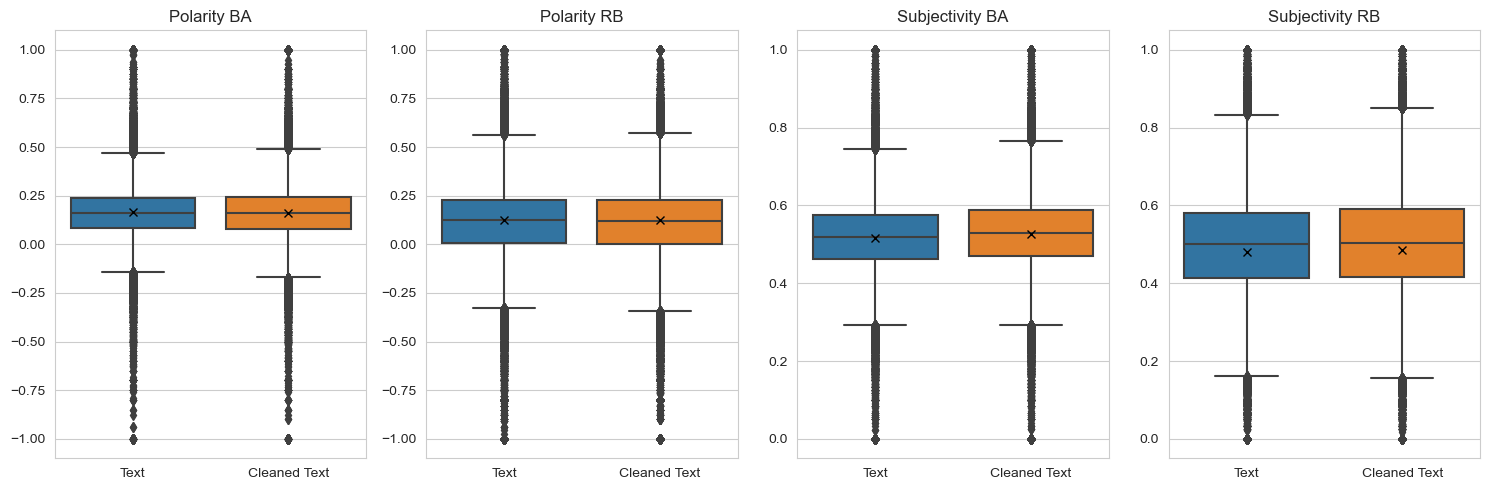

In [75]:
fig, axs = plt.subplots(1,4, figsize=(15, 5))
sns.boxplot(data = ratings_BA_cleaned[['polarity_text', 'polarity_cleaned_text']], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[0])
sns.boxplot(data = ratings_RB_cleaned[['polarity_text', 'polarity_cleaned_text']], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[1])

sns.boxplot(data = ratings_BA_cleaned[['subjectivity_text', 'subjectivity_cleaned_text']], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[2])
sns.boxplot(data = ratings_RB_cleaned[['subjectivity_text', 'subjectivity_cleaned_text']], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[3])

for i in range(4):
    axs[i].set_xticklabels(['Text', 'Cleaned Text'])

axs[0].set_title(f"Polarity BA")
axs[1].set_title(f"Polarity RB")
axs[2].set_title(f"Subjectivity BA")
axs[3].set_title(f"Subjectivity RB")
plt.tight_layout()
plt.show()

These polarity’s boxplots and subjectivity’s boxplots help us to valide our idea. Indeed, we observe that our idea to create a new ranking’s system with less subjectivity, and with less weight for extreme user’s opinion which can be ponderated to limit their influence on the beer’s ranking seems to be feasible and relevant. Then, the average which is not a robust parameter would be fairer. We also see that there is not much difference between the text and cleaned text, so that we will later only use the cleaned text to perform sentiment analysis.

**Polarity - subjectivity per brewery**

In [76]:
def plot_polarity_subjectivity_per_topk_brewery(website):
    if website == 'BeerAdvocate': 
        df = ratings_BA_cleaned
    else:
        df = ratings_RB_cleaned
    k_breweries = 0.9995
    ratings_topk_breweries = filter_topk_breweries(df, k_breweries)

    fig, axs = plt.subplots(1,2, figsize=(15, 6), sharey = True)
    sns.boxplot(data = ratings_topk_breweries, x = 'polarity_text', y = 'style', showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[0])
    sns.boxplot(data = ratings_topk_breweries, x = 'subjectivity_text', y = 'style', showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[1])

    axs[0].set_title(f"Polarity top {np.round(100*(1-k_breweries),3)} % breweries")
    axs[1].set_title(f"Subjectivity top {np.round(100*(1-k_breweries),3)} % breweries")

    plt.tight_layout()
    plt.show()

##### Beer Advocate

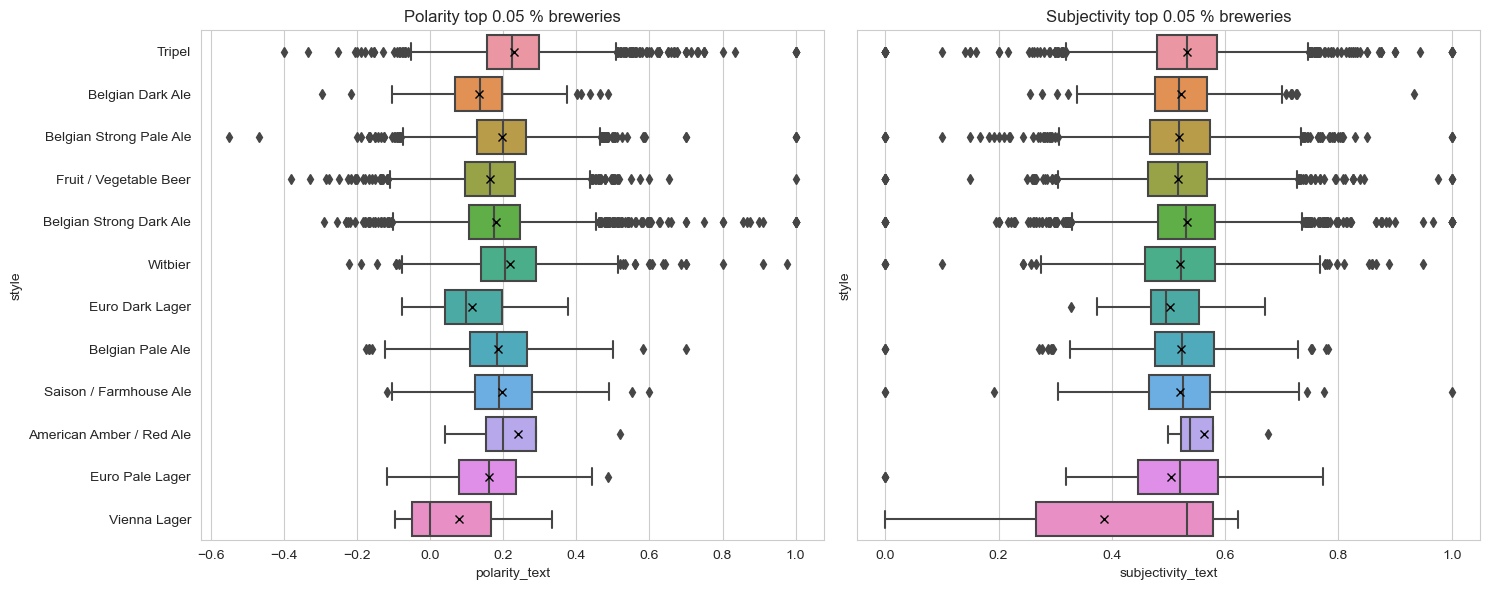

##### RateBeers

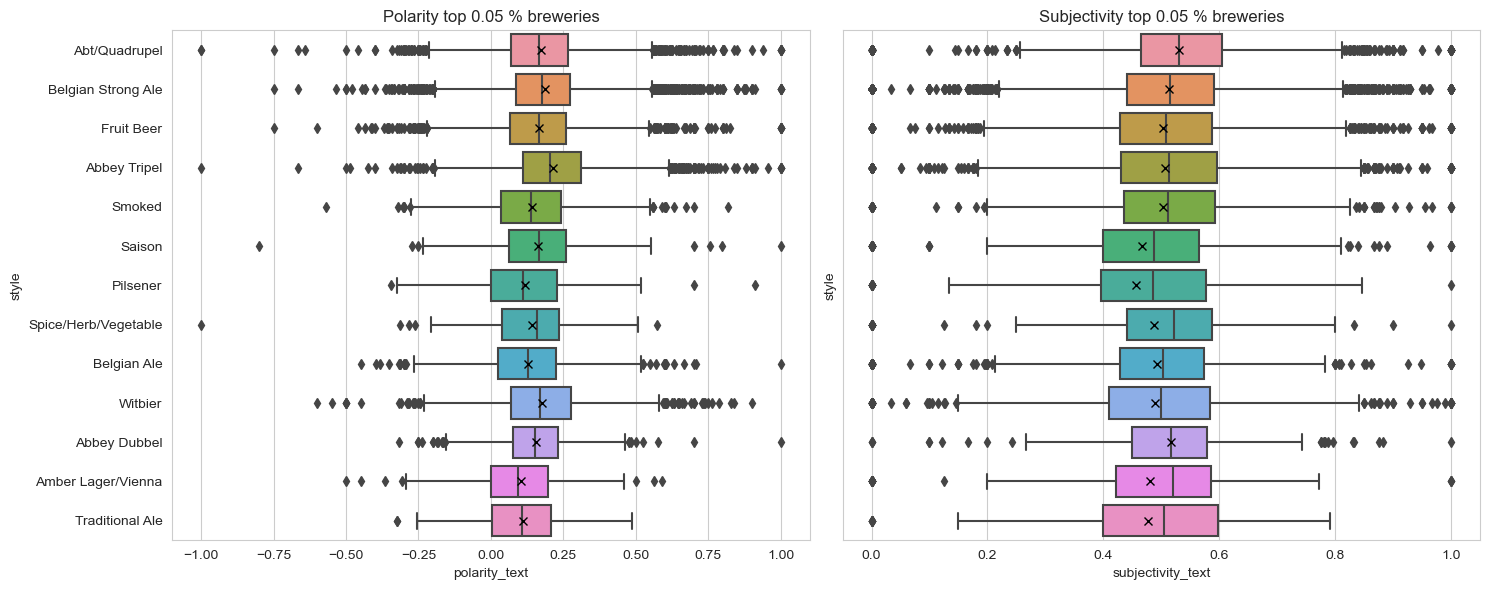

In [77]:
display(Markdown("##### Beer Advocate"))
plot_polarity_subjectivity_per_topk_brewery(website = 'BeerAdvocate')
display(Markdown("##### RateBeers"))
plot_polarity_subjectivity_per_topk_brewery(website = 'RateBeer')

One can note that the polarity and subjectivity of textual reviews depends on the brewery we look at. Some have more extreme outliers than others and typically for BeerAdvocate, one can note that even the mean of the polarity is different.

**Polarity - subjectivity per style**

In [78]:
def plot_polarity_subjectivity_per_topk_style(website):
    if website == 'BeerAdvocate': 
        df = ratings_BA_cleaned
    else:
        df = ratings_RB_cleaned
    k_styles = 0.9
    ratings_topk_styles = filter_topk_styles(df, k_styles)

    fig, axs = plt.subplots(1,2, figsize=(15, 4), sharey = True)
    sns.boxplot(data = ratings_topk_styles, x = 'polarity_text', y = 'style', showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[0])
    sns.boxplot(data = ratings_topk_styles, x = 'subjectivity_text', y = 'style', showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[1])

    axs[0].set_title(f"Polarity top {np.round(100*(1-k_styles),0)} % styles")
    axs[1].set_title(f"Subjectivity top {np.round(100*(1-k_styles),0)} % styles")

    plt.tight_layout()
    plt.show()

##### BeerAdvocate

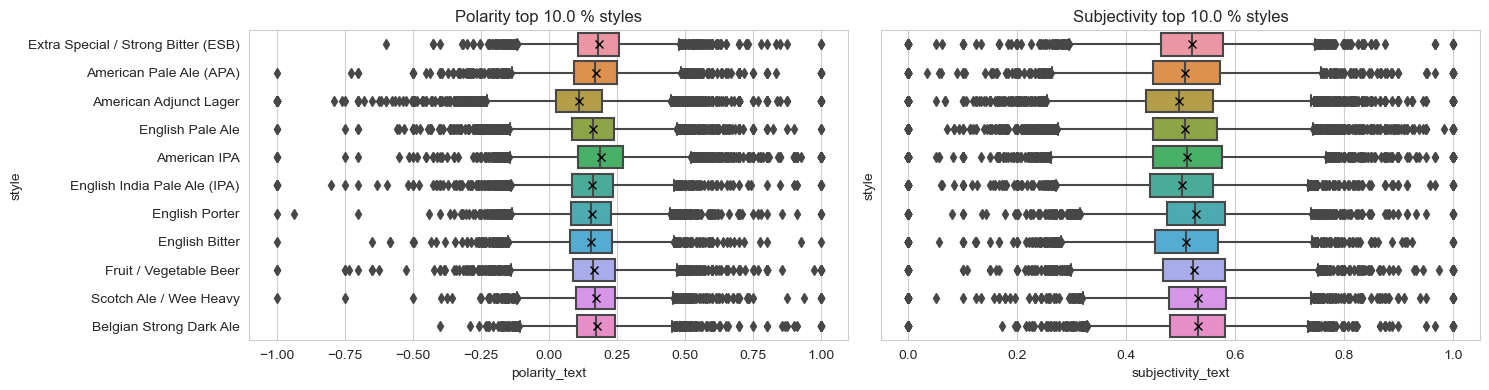

##### RateBeers

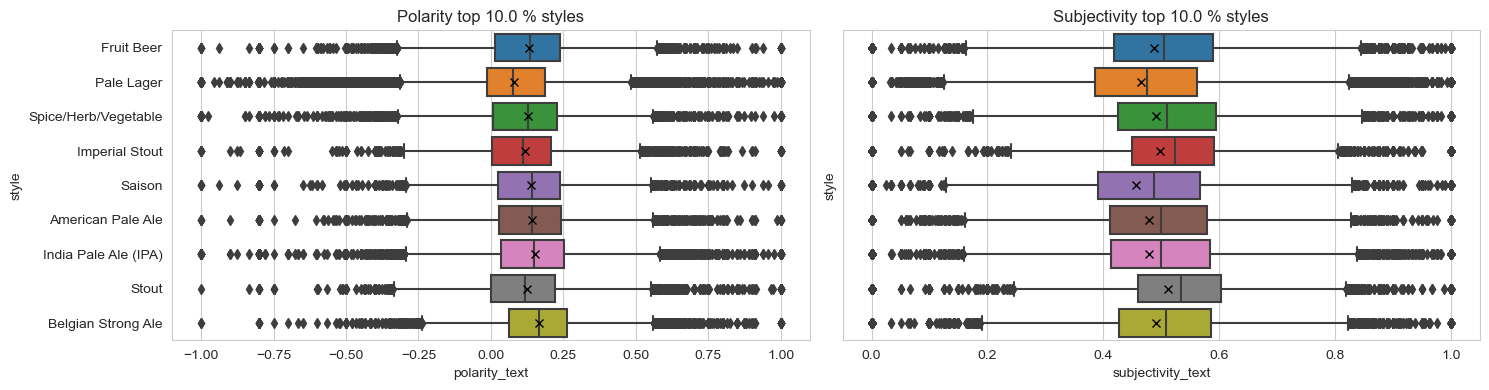

In [79]:
display(Markdown("##### BeerAdvocate"))
plot_polarity_subjectivity_per_topk_style(website = 'BeerAdvocate')
display(Markdown("##### RateBeers"))
plot_polarity_subjectivity_per_topk_style(website = 'RateBeer')

One can note that the polarity and subjectivity of textual reviews depends also on the style of the beer we look at. Some have more extreme outliers than others eventhough one can note that the differences of polarity and subjectivity of the textual reviews across styles are less important than for breweries.

It thus support the feasibility of our research project to create a weighted ranking system taking into account the discrepancies of polarity and subjectivity of the textual reviews across breweries, styles and ultimately users to have an enhanced ranking system that leverage numerical ratings and textual reviews.